# Assignment 05
The goal of this assignment is to build a simple, modular, extensible, machine learning pipeline in Python. The problem is to predict if a project on donorschoose will not get fully funded within 60 days of posting.

The data set below is a modified version of data from https://www.kaggle.com/c/GiveMeSomeCredit

### Setup

In [1]:
import data_processing as dp
import classifiers as cfs

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.svm import LinearSVC
%load_ext autoreload
%autoreload 2

### Parameters
The following are the parameters used to analyze this specific dataset. If modified, the user might have to run the whole code again.

In [3]:
PARAMS = {
          'seed': 2222,
          'data_filepath': "data/projects_2012_2013.csv",
          'var_types': {'projectid':str,
                        'teacher_acctid':str,
                        'schoolid':str,
                        'school_ncesid':str,
                        'school_latitude':float, 
                        'school_longitude':float},
          'geometry': {"long": "school_longitude",
                       "lat": "school_latitude"},
          'id_cols': ['projectid',
                      'teacher_acctid',
                      'schoolid',
                      'school_ncesid'],
          'date_cols': ["date_posted",
                        "datefullyfunded"],
          'test_size': 0.3,
          'preciction_gap': 60, # days
          'target_feature': 'not_funded_within_60days',
          'train_len': 365//2, # days
          'grid_size': 'med',
          # size of the grid to run the models. Only run large when sure about
          # the functionality, as it will be computationally expensive
          'thresholds': [1, 2, 5, 10, 20, 30, 50]
}

## 1) Load Data

In [4]:
df = dp.get_projects_df(PARAMS['data_filepath'])

In [5]:
df.shape

(124976, 26)

In [6]:
df.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded',
       'female_teacher'],
      dtype='object')

In [7]:
df.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,...,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded,female_teacher
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.70993E+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,...,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,False,2013-04-14,2013-05-02,True
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,64098006751,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,...,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,True,2012-04-07,2012-04-18,True
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,62271003143,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,...,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,False,2012-01-30,2012-04-15,True
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.60009E+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,...,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,False,2012-10-11,2012-12-05,True
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.60687E+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,...,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,False,2013-01-08,2013-03-25,True


### 1.1 Create outcome variable

In [8]:
dp.create_period_outcome(df, initial_date=PARAMS['date_cols'][0], end_date=PARAMS['date_cols'][1])
# set in the PARAMS dictionary the name of the outcome feature
PARAMS['target'] = dp.get_outcome_lbl()

Created outcomes label


## 2) Explore Data

### 2.1 Sumary of data

In [9]:
dp.describe_data(df, PARAMS['date_cols'])

Number of obs: 124976

Columns with missing data: ['school_ncesid', 'school_metro', 'school_district', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'grade_level', 'students_reached', 'not_funded_within_60days']

Description of numeric features:

       school_latitude  school_longitude  \
count    124976.000000     124976.000000   
mean         36.827284        -95.859299   
std           4.963669         18.392876   
min          18.249140       -171.690554   
25%          33.872504       -117.806418   
50%          36.617410        -90.101563   
75%          40.676156        -80.713740   
max          65.672562        -66.628036   

       total_price_including_optional_support  students_reached  \
count                           124976.000000     124917.000000   
mean                               654.011811         95.445760   
std                               1098.015854        163.481912   
min                

Correlation matrix:


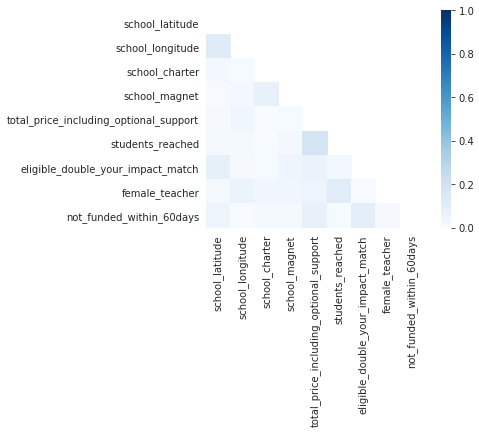

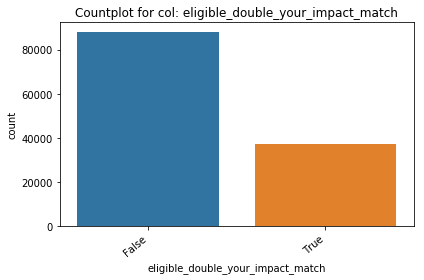

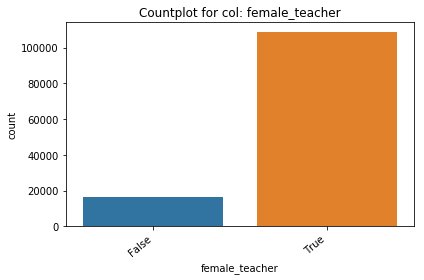

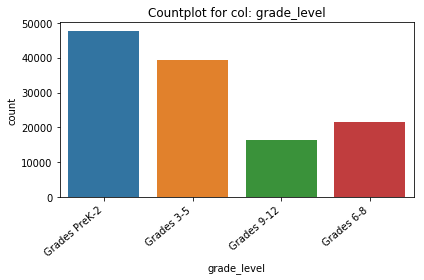

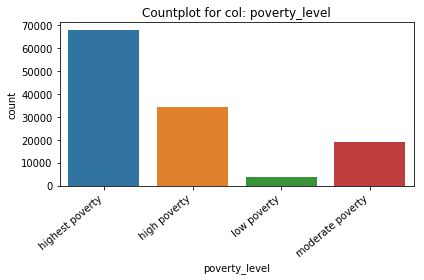

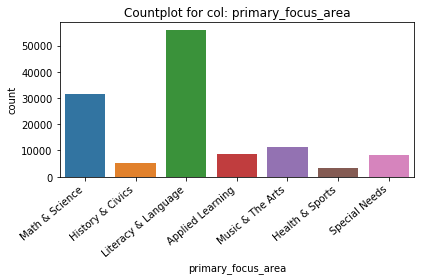

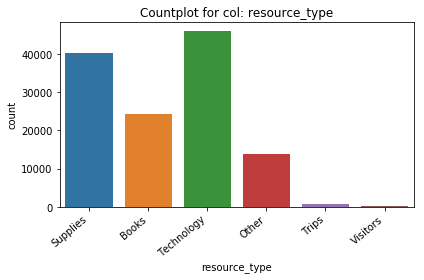

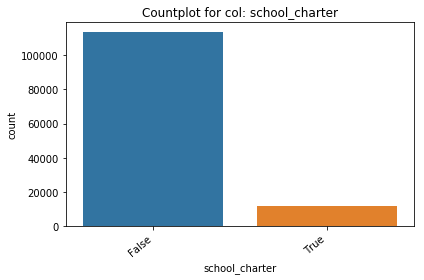

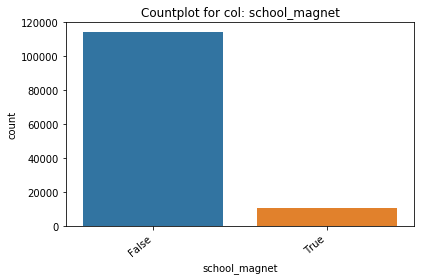

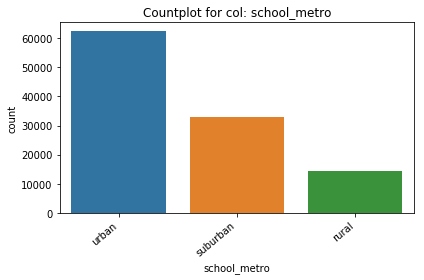

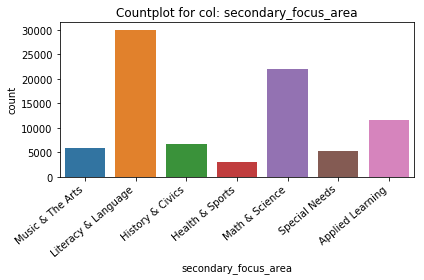

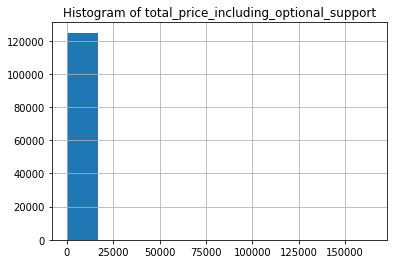

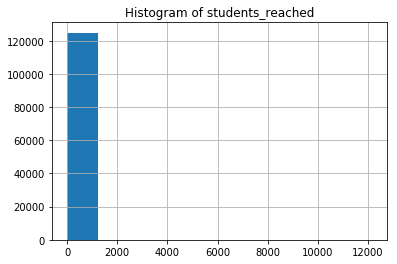

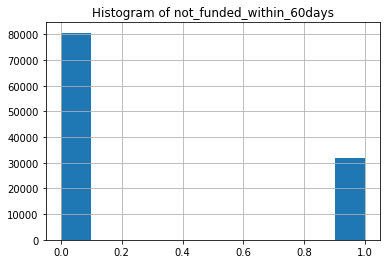

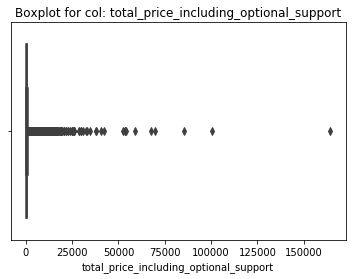

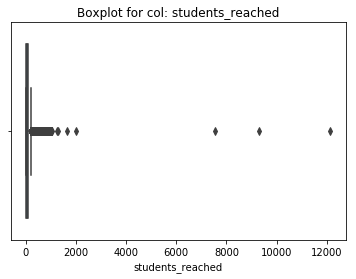

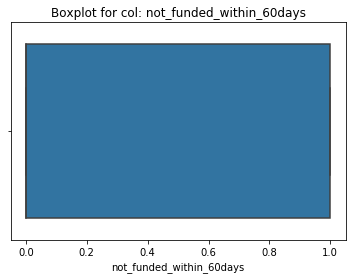

In [10]:
dp.view_data(df)

## 4) Generate and process temporal validation sets

In [20]:
temporal_dfs = dp.get_temporal_dfs(df=df,
                                   d_col=PARAMS['date_cols'][0],
                                   target_col=PARAMS['target_feature'],
                                   prediction_gap=PARAMS['preciction_gap'],
                                   pred_win_len=PARAMS['train_len'])

Creating binary columns: ['grade_level', 'poverty_level', 'primary_focus_area', 'resource_type', 'school_metro', 'secondary_focus_area']

Complete data set has 124976 obs and 58 variables

Working with train/test set split at: 2012-07-01 00:00:00
	 Working with train df
		 Filling missing values...
		 Discretizing continous columns...
		 Creating missing binary columns of just created discretized columns...
	 Train DF starts at 2012-01-01 00:00:00, ends at 2012-05-02 00:00:00, has 21423 obs and 68 cols

	 Working with test df
		 Filling missing values...
		 Discretizing continous columns...
		 Creating missing binary columns of just created discretized columns...
	 Test DF starts at 2012-07-02 00:00:00, ends at 2012-10-31 00:00:00, has 23063 obs and 68 cols

Working with train/test set split at: 2012-12-30 00:00:00
	 Working with train df
		 Filling missing values...
		 Discretizing continous columns...
		 Creating missing binary columns of just created discretized columns...
	 Train D

## 5) Get models and grid, and train

#### Testing for RFs

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
RF_grid = {'RF':   {'n_estimators': [1, 10, 100, 1000, 10000], 
                 'max_depth': [5,50], 
                 'max_features': ['sqrt','log2'],
                 'min_samples_split': [2,10], 
                 'n_jobs':[-1]}
          }

In [27]:
RF_clf = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1)}

Start time: 11_44_33


Working with:  RF

	Model 1
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predicted.
		Added metrics row in results.


<Figure size 432x288 with 0 Axes>

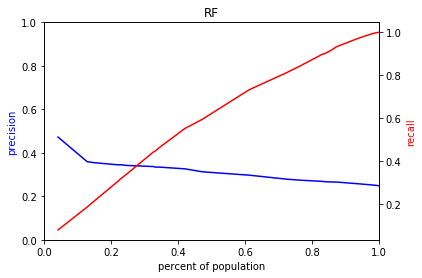

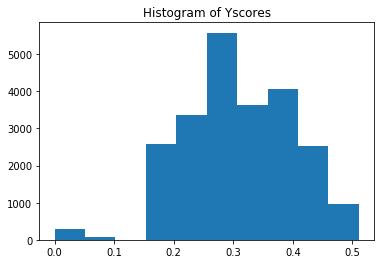

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.254139)
2. Feature resource_type_Technology (0.166715)
3. Feature total_price_including_optional_support_discrete_low (0.129539)
4. Feature resource_type_Books (0.127338)
5. Feature eligible_double_your_impact_match (0.089763)
6. Feature primary_focus_area_Music & The Arts (0.062247)
7. Feature school_metro_urban (0.040544)
8. Feature school_metro_suburban (0.036354)
9. Feature primary_focus_area_Literacy & Language (0.015958)
10. Feature students_reached_discrete_low (0.014222)

	Model 2
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_star

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

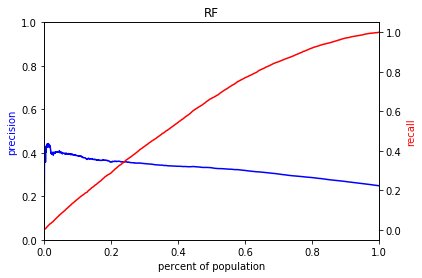

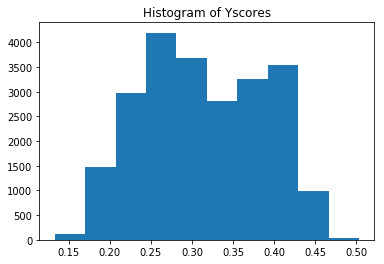

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.247288)
2. Feature total_price_including_optional_support_discrete_low (0.209154)
3. Feature resource_type_Technology (0.098322)
4. Feature eligible_double_your_impact_match (0.090295)
5. Feature total_price_including_optional_support_discrete_med (0.053160)
6. Feature poverty_level_highest poverty (0.026292)
7. Feature resource_type_Books (0.024905)
8. Feature total_price_including_optional_support_discrete_bottom_outlier (0.023680)
9. Feature primary_focus_area_Music & The Arts (0.022578)
10. Feature primary_focus_area_Math & Science (0.018414)

	Model 3
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
          

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

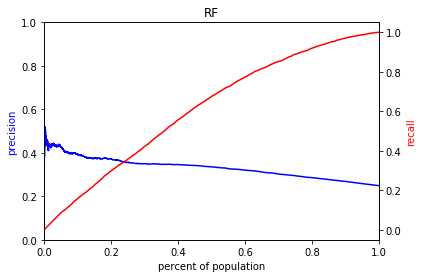

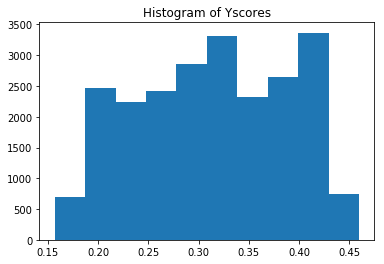

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.291585)
2. Feature total_price_including_optional_support_discrete_high (0.185564)
3. Feature eligible_double_your_impact_match (0.136126)
4. Feature resource_type_Technology (0.078991)
5. Feature total_price_including_optional_support_discrete_med (0.032469)
6. Feature total_price_including_optional_support_discrete_bottom_outlier (0.026954)
7. Feature poverty_level_highest poverty (0.023976)
8. Feature primary_focus_area_Literacy & Language (0.023310)
9. Feature resource_type_Trips (0.019369)
10. Feature resource_type_Books (0.018926)

	Model 4
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_scor

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

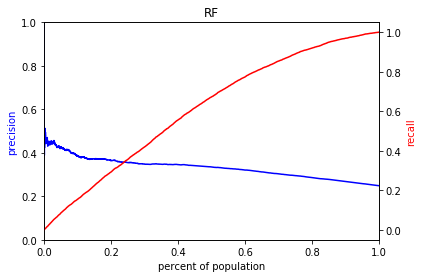

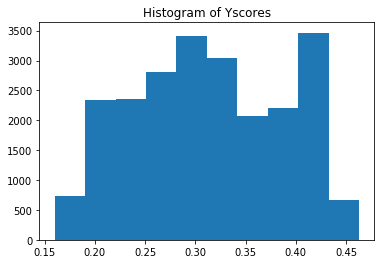

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.266283)
2. Feature total_price_including_optional_support_discrete_high (0.213815)
3. Feature eligible_double_your_impact_match (0.140936)
4. Feature resource_type_Technology (0.064087)
5. Feature total_price_including_optional_support_discrete_med (0.033597)
6. Feature resource_type_Trips (0.027179)
7. Feature total_price_including_optional_support_discrete_bottom_outlier (0.023768)
8. Feature resource_type_Books (0.021503)
9. Feature primary_focus_area_Literacy & Language (0.021359)
10. Feature poverty_level_highest poverty (0.018871)

	Model 5
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_sco

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

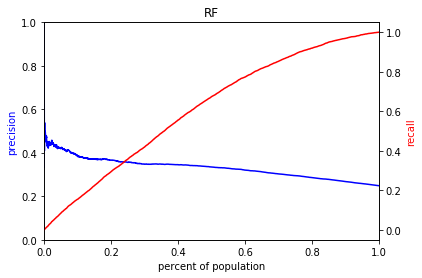

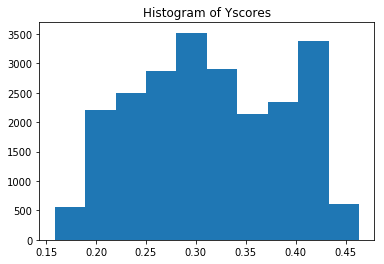

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.253165)
2. Feature total_price_including_optional_support_discrete_high (0.218133)
3. Feature eligible_double_your_impact_match (0.140329)
4. Feature resource_type_Technology (0.065552)
5. Feature total_price_including_optional_support_discrete_med (0.033869)
6. Feature resource_type_Trips (0.027278)
7. Feature total_price_including_optional_support_discrete_bottom_outlier (0.022939)
8. Feature resource_type_Books (0.022318)
9. Feature primary_focus_area_Literacy & Language (0.021721)
10. Feature poverty_level_highest poverty (0.019816)

	Model 6
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

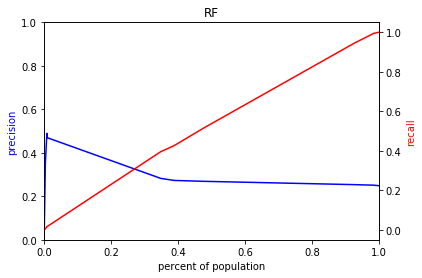

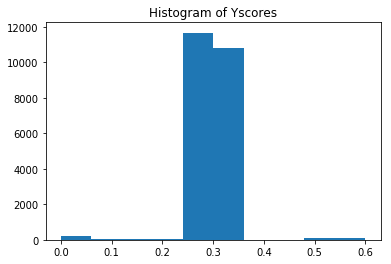

FEATURE IMPORTANCES

1. Feature poverty_level_highest poverty (0.250267)
2. Feature total_price_including_optional_support_discrete_bottom_outlier (0.219858)
3. Feature total_price_including_optional_support_discrete_top_outlier (0.136559)
4. Feature resource_type_Books (0.124698)
5. Feature secondary_focus_area_Music & The Arts (0.112102)
6. Feature resource_type_Other (0.063456)
7. Feature secondary_focus_area_nan (0.017837)
8. Feature poverty_level_moderate poverty (0.014359)
9. Feature primary_focus_area_Music & The Arts (0.013301)
10. Feature grade_level_Grades 3-5 (0.012993)

	Model 7
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
    

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

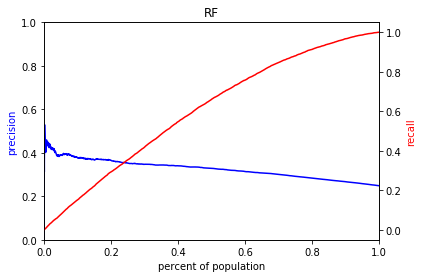

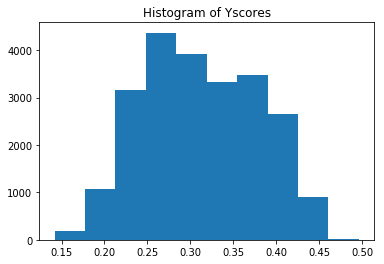

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.282144)
2. Feature eligible_double_your_impact_match (0.154231)
3. Feature total_price_including_optional_support_discrete_low (0.141619)
4. Feature resource_type_Technology (0.052260)
5. Feature poverty_level_highest poverty (0.050579)
6. Feature resource_type_Trips (0.039645)
7. Feature primary_focus_area_Literacy & Language (0.037427)
8. Feature total_price_including_optional_support_discrete_bottom_outlier (0.021300)
9. Feature primary_focus_area_Music & The Arts (0.020298)
10. Feature resource_type_Books (0.019184)

	Model 8
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

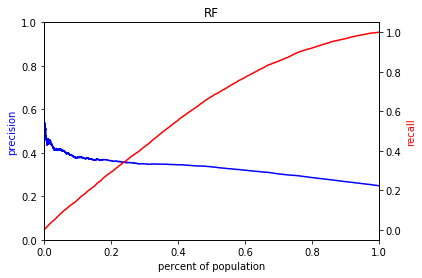

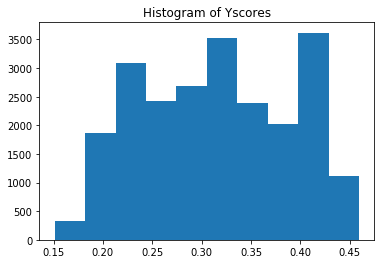

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.281052)
2. Feature total_price_including_optional_support_discrete_high (0.209325)
3. Feature eligible_double_your_impact_match (0.134785)
4. Feature resource_type_Technology (0.054436)
5. Feature total_price_including_optional_support_discrete_med (0.040648)
6. Feature resource_type_Trips (0.033831)
7. Feature total_price_including_optional_support_discrete_bottom_outlier (0.023880)
8. Feature primary_focus_area_Literacy & Language (0.022318)
9. Feature resource_type_Books (0.020150)
10. Feature poverty_level_highest poverty (0.016515)

	Model 9
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_sco

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

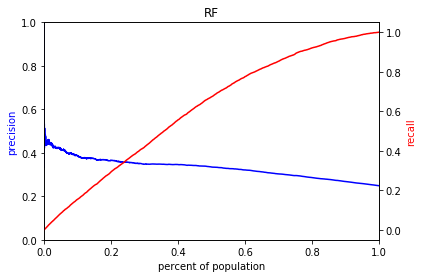

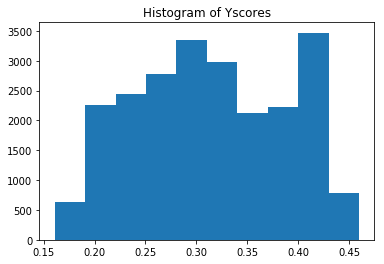

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.255314)
2. Feature total_price_including_optional_support_discrete_high (0.215228)
3. Feature eligible_double_your_impact_match (0.140642)
4. Feature resource_type_Technology (0.065206)
5. Feature total_price_including_optional_support_discrete_med (0.035339)
6. Feature resource_type_Trips (0.028189)
7. Feature total_price_including_optional_support_discrete_bottom_outlier (0.025604)
8. Feature primary_focus_area_Literacy & Language (0.022868)
9. Feature resource_type_Books (0.021085)
10. Feature poverty_level_highest poverty (0.019153)

	Model 10
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_s

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

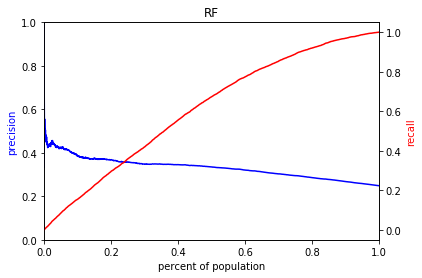

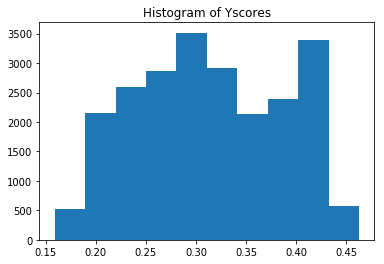

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.256863)
2. Feature total_price_including_optional_support_discrete_high (0.214520)
3. Feature eligible_double_your_impact_match (0.140950)
4. Feature resource_type_Technology (0.066287)
5. Feature total_price_including_optional_support_discrete_med (0.031865)
6. Feature resource_type_Trips (0.028208)
7. Feature total_price_including_optional_support_discrete_bottom_outlier (0.023599)
8. Feature resource_type_Books (0.022099)
9. Feature primary_focus_area_Literacy & Language (0.021952)
10. Feature poverty_level_highest poverty (0.019890)

	Model 11
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

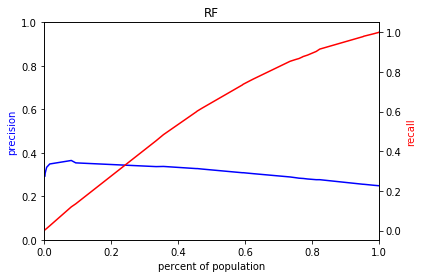

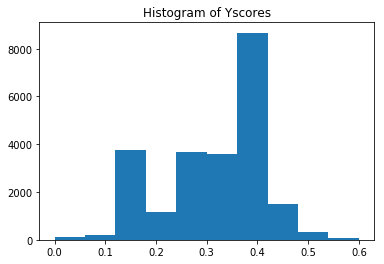

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.421956)
2. Feature total_price_including_optional_support_discrete_high (0.200114)
3. Feature resource_type_Trips (0.066809)
4. Feature total_price_including_optional_support_discrete_med (0.057871)
5. Feature poverty_level_high poverty (0.050391)
6. Feature primary_focus_area_Music & The Arts (0.037894)
7. Feature eligible_double_your_impact_match (0.036896)
8. Feature resource_type_Technology (0.030998)
9. Feature school_metro_urban (0.023214)
10. Feature resource_type_Other (0.016232)

	Model 12
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

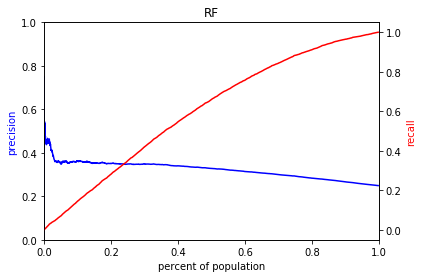

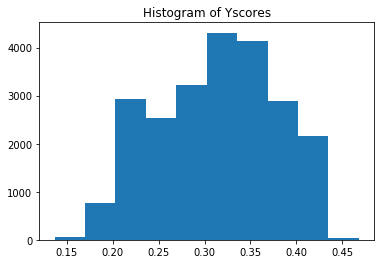

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.269238)
2. Feature eligible_double_your_impact_match (0.183471)
3. Feature total_price_including_optional_support_discrete_high (0.128884)
4. Feature resource_type_Technology (0.113962)
5. Feature total_price_including_optional_support_discrete_bottom_outlier (0.040220)
6. Feature poverty_level_highest poverty (0.039974)
7. Feature total_price_including_optional_support_discrete_med (0.039902)
8. Feature resource_type_Trips (0.022032)
9. Feature poverty_level_high poverty (0.013460)
10. Feature primary_focus_area_Literacy & Language (0.011827)

	Model 13
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            o

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

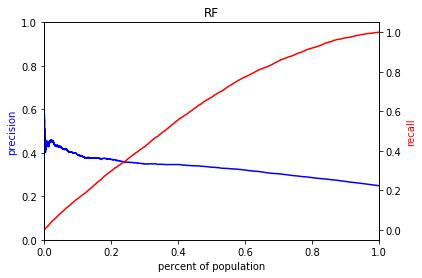

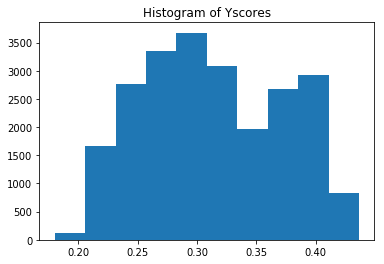

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.220590)
2. Feature total_price_including_optional_support_discrete_low (0.200471)
3. Feature eligible_double_your_impact_match (0.153187)
4. Feature resource_type_Technology (0.080838)
5. Feature resource_type_Trips (0.027081)
6. Feature resource_type_Books (0.026995)
7. Feature total_price_including_optional_support_discrete_bottom_outlier (0.024821)
8. Feature primary_focus_area_Literacy & Language (0.023372)
9. Feature poverty_level_highest poverty (0.021054)
10. Feature total_price_including_optional_support_discrete_med (0.020278)

	Model 14
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_sco

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

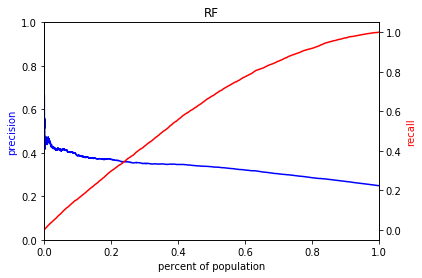

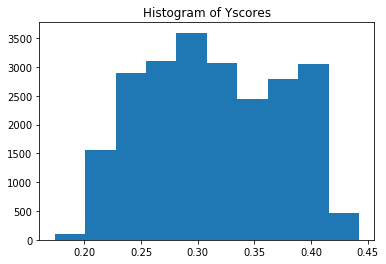

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.236113)
2. Feature total_price_including_optional_support_discrete_high (0.214812)
3. Feature eligible_double_your_impact_match (0.131427)
4. Feature resource_type_Technology (0.068787)
5. Feature resource_type_Trips (0.028260)
6. Feature resource_type_Books (0.028008)
7. Feature total_price_including_optional_support_discrete_bottom_outlier (0.025196)
8. Feature primary_focus_area_Literacy & Language (0.024377)
9. Feature total_price_including_optional_support_discrete_med (0.023829)
10. Feature poverty_level_highest poverty (0.021729)

	Model 15
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_sc

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

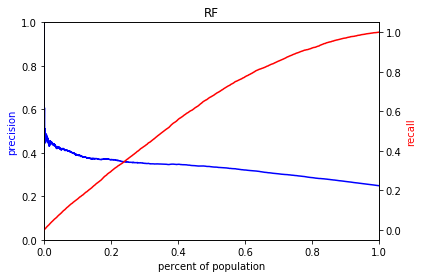

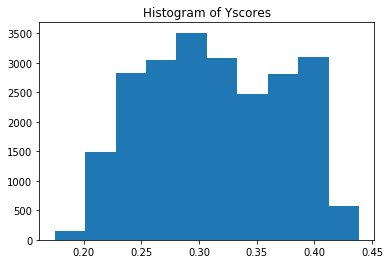

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.238278)
2. Feature total_price_including_optional_support_discrete_high (0.207254)
3. Feature eligible_double_your_impact_match (0.130470)
4. Feature resource_type_Technology (0.071609)
5. Feature resource_type_Trips (0.028481)
6. Feature resource_type_Books (0.026788)
7. Feature total_price_including_optional_support_discrete_bottom_outlier (0.025245)
8. Feature total_price_including_optional_support_discrete_med (0.024664)
9. Feature primary_focus_area_Literacy & Language (0.024394)
10. Feature poverty_level_highest poverty (0.022436)

	Model 16
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

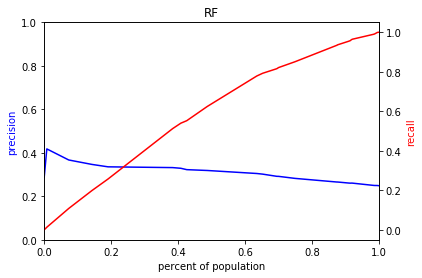

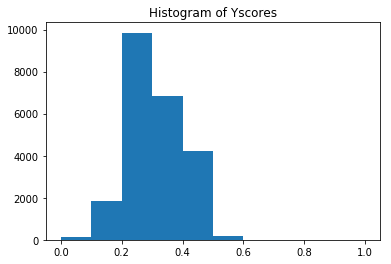

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.518282)
2. Feature total_price_including_optional_support_discrete_med (0.134203)
3. Feature eligible_double_your_impact_match (0.081170)
4. Feature poverty_level_highest poverty (0.056107)
5. Feature primary_focus_area_Music & The Arts (0.045899)
6. Feature total_price_including_optional_support_discrete_high (0.034032)
7. Feature resource_type_Other (0.033916)
8. Feature school_metro_nan (0.016435)
9. Feature school_metro_urban (0.015883)
10. Feature secondary_focus_area_Literacy & Language (0.014564)

	Model 17
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbos

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

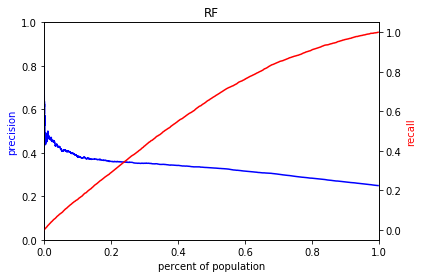

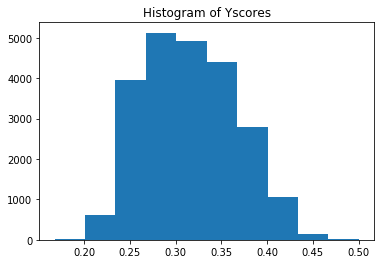

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.283111)
2. Feature total_price_including_optional_support_discrete_low (0.152916)
3. Feature resource_type_Technology (0.064206)
4. Feature resource_type_Trips (0.057067)
5. Feature eligible_double_your_impact_match (0.056001)
6. Feature primary_focus_area_Music & The Arts (0.038110)
7. Feature poverty_level_highest poverty (0.036780)
8. Feature primary_focus_area_Literacy & Language (0.036300)
9. Feature total_price_including_optional_support_discrete_top_outlier (0.032131)
10. Feature total_price_including_optional_support_discrete_med (0.029475)

	Model 18
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
      

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

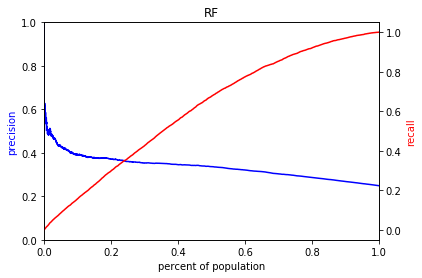

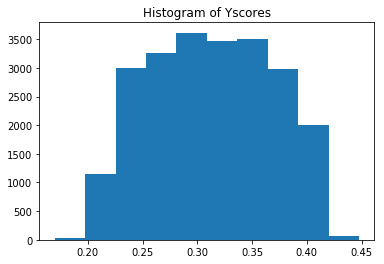

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.245733)
2. Feature total_price_including_optional_support_discrete_high (0.180983)
3. Feature eligible_double_your_impact_match (0.109687)
4. Feature resource_type_Technology (0.095677)
5. Feature total_price_including_optional_support_discrete_bottom_outlier (0.037643)
6. Feature resource_type_Trips (0.027692)
7. Feature primary_focus_area_Literacy & Language (0.025534)
8. Feature resource_type_Books (0.025493)
9. Feature poverty_level_highest poverty (0.024132)
10. Feature total_price_including_optional_support_discrete_med (0.021449)

	Model 19
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_sc

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

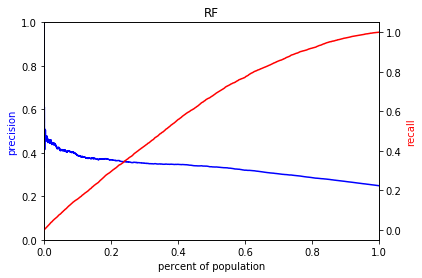

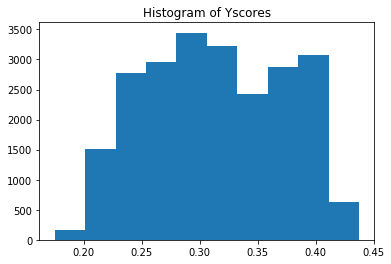

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.238234)
2. Feature total_price_including_optional_support_discrete_high (0.204412)
3. Feature eligible_double_your_impact_match (0.128807)
4. Feature resource_type_Technology (0.072761)
5. Feature resource_type_Trips (0.029992)
6. Feature resource_type_Books (0.027608)
7. Feature total_price_including_optional_support_discrete_bottom_outlier (0.024936)
8. Feature total_price_including_optional_support_discrete_med (0.024788)
9. Feature primary_focus_area_Literacy & Language (0.022853)
10. Feature poverty_level_highest poverty (0.022143)

	Model 20
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_s

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

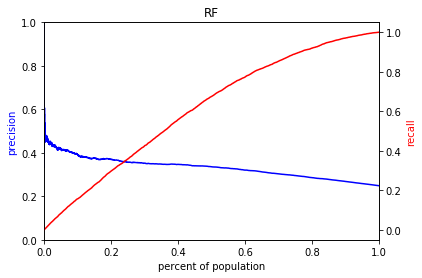

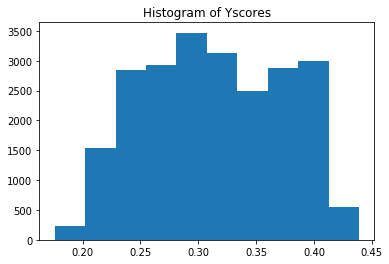

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.240430)
2. Feature total_price_including_optional_support_discrete_high (0.204631)
3. Feature eligible_double_your_impact_match (0.130720)
4. Feature resource_type_Technology (0.073076)
5. Feature resource_type_Trips (0.027838)
6. Feature resource_type_Books (0.026930)
7. Feature total_price_including_optional_support_discrete_med (0.025754)
8. Feature total_price_including_optional_support_discrete_bottom_outlier (0.025597)
9. Feature primary_focus_area_Literacy & Language (0.023785)
10. Feature poverty_level_highest poverty (0.022124)

	Model 21
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

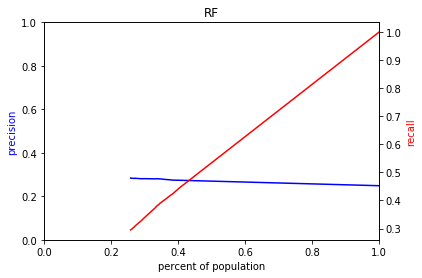

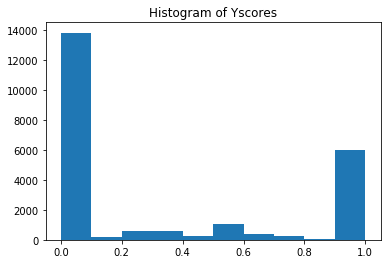

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.064752)
2. Feature female_teacher (0.047587)
3. Feature secondary_focus_area_nan (0.040393)
4. Feature school_magnet (0.040391)
5. Feature students_reached_discrete_med (0.037270)
6. Feature students_reached_discrete_low (0.035586)
7. Feature secondary_focus_area_Literacy & Language (0.034311)
8. Feature school_charter (0.033898)
9. Feature primary_focus_area_Literacy & Language (0.033844)
10. Feature poverty_level_high poverty (0.032305)

	Model 22
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predic

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

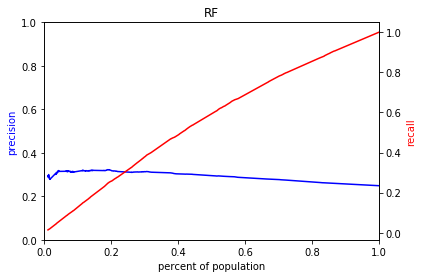

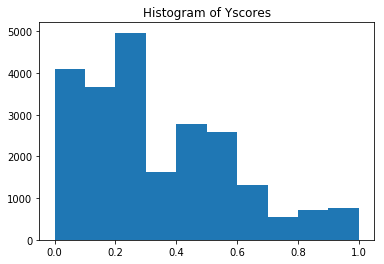

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.046157)
2. Feature female_teacher (0.044295)
3. Feature school_magnet (0.040770)
4. Feature secondary_focus_area_nan (0.037348)
5. Feature grade_level_Grades 3-5 (0.033981)
6. Feature secondary_focus_area_Literacy & Language (0.033202)
7. Feature school_charter (0.031858)
8. Feature students_reached_discrete_low (0.031248)
9. Feature school_metro_urban (0.031152)
10. Feature students_reached_discrete_med (0.031079)

	Model 23
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predicted.
		Added metrics ro

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

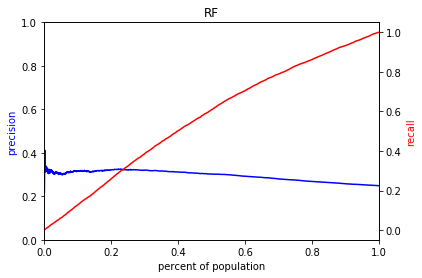

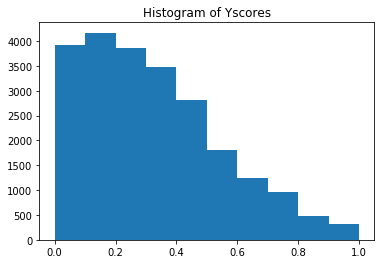

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.048296)
2. Feature female_teacher (0.044537)
3. Feature school_magnet (0.040083)
4. Feature secondary_focus_area_nan (0.037553)
5. Feature students_reached_discrete_med (0.034373)
6. Feature secondary_focus_area_Literacy & Language (0.033698)
7. Feature school_charter (0.032408)
8. Feature students_reached_discrete_low (0.031803)
9. Feature students_reached_discrete_high (0.030630)
10. Feature grade_level_Grades 3-5 (0.030546)

	Model 24
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predicted.
		Add

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

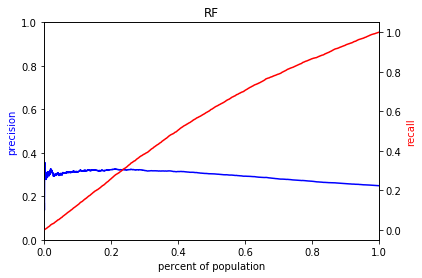

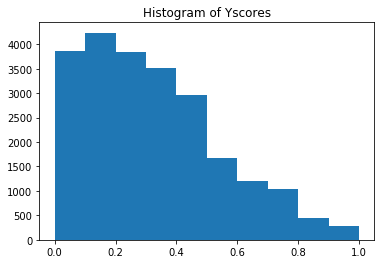

FEATURE IMPORTANCES

1. Feature female_teacher (0.044421)
2. Feature eligible_double_your_impact_match (0.043776)
3. Feature school_magnet (0.039746)
4. Feature secondary_focus_area_nan (0.037062)
5. Feature students_reached_discrete_med (0.034878)
6. Feature secondary_focus_area_Literacy & Language (0.033029)
7. Feature students_reached_discrete_low (0.032393)
8. Feature school_charter (0.032131)
9. Feature grade_level_Grades 3-5 (0.031669)
10. Feature students_reached_discrete_high (0.030680)

	Model 25
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predicted.
		Ad

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

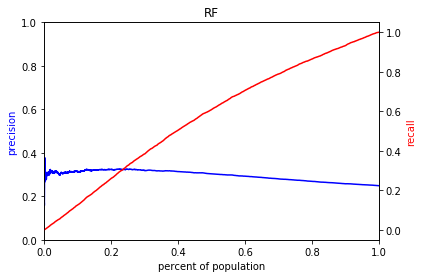

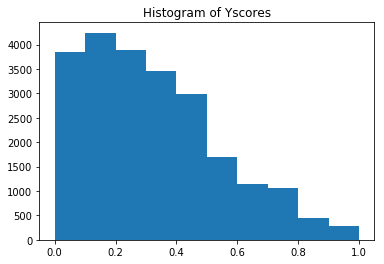

FEATURE IMPORTANCES

1. Feature female_teacher (0.044313)
2. Feature eligible_double_your_impact_match (0.044021)
3. Feature school_magnet (0.039844)
4. Feature secondary_focus_area_nan (0.037472)
5. Feature students_reached_discrete_med (0.034772)
6. Feature secondary_focus_area_Literacy & Language (0.033267)
7. Feature students_reached_discrete_low (0.032532)
8. Feature school_charter (0.032116)
9. Feature grade_level_Grades 3-5 (0.031536)
10. Feature students_reached_discrete_high (0.030371)

	Model 26
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predicted.
		Added

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

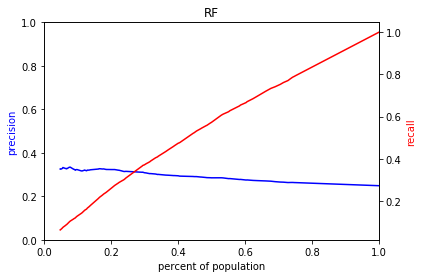

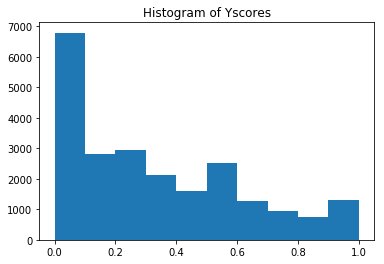

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.054791)
2. Feature eligible_double_your_impact_match (0.052348)
3. Feature secondary_focus_area_Literacy & Language (0.039902)
4. Feature school_magnet (0.039802)
5. Feature secondary_focus_area_nan (0.039336)
6. Feature school_metro_urban (0.037316)
7. Feature total_price_including_optional_support_discrete_high (0.036007)
8. Feature female_teacher (0.034279)
9. Feature students_reached_discrete_low (0.031992)
10. Feature poverty_level_moderate poverty (0.030558)

	Model 27
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Su

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

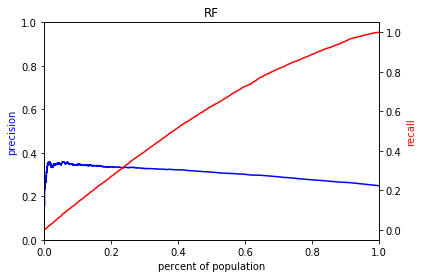

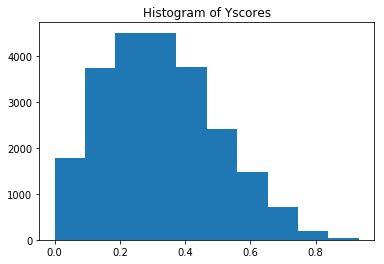

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.051605)
2. Feature total_price_including_optional_support_discrete_high (0.049725)
3. Feature total_price_including_optional_support_discrete_low (0.045778)
4. Feature female_teacher (0.032275)
5. Feature school_magnet (0.032089)
6. Feature secondary_focus_area_nan (0.030681)
7. Feature school_charter (0.030513)
8. Feature secondary_focus_area_Literacy & Language (0.029457)
9. Feature primary_focus_area_Literacy & Language (0.028601)
10. Feature resource_type_Technology (0.028375)

	Model 28
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Su

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

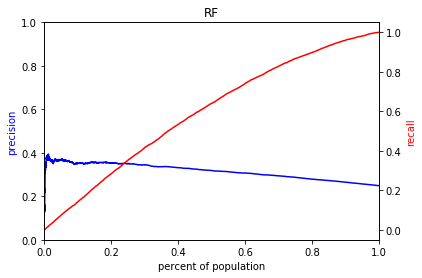

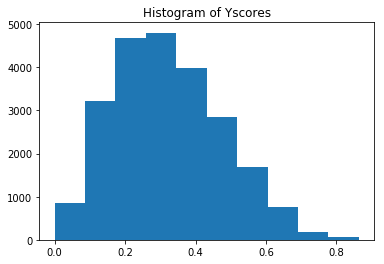

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.050857)
2. Feature total_price_including_optional_support_discrete_low (0.048969)
3. Feature total_price_including_optional_support_discrete_high (0.042183)
4. Feature female_teacher (0.032138)
5. Feature secondary_focus_area_nan (0.031620)
6. Feature school_magnet (0.031189)
7. Feature secondary_focus_area_Literacy & Language (0.029994)
8. Feature students_reached_discrete_med (0.028680)
9. Feature school_charter (0.028034)
10. Feature students_reached_discrete_low (0.027269)

	Model 29
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succe

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

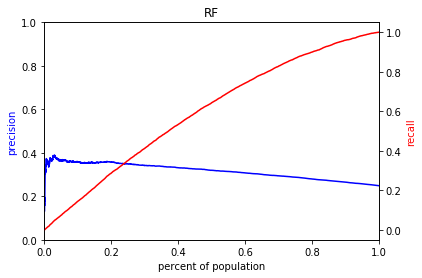

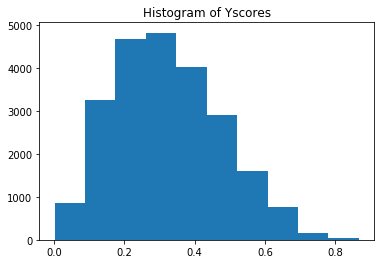

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.050937)
2. Feature total_price_including_optional_support_discrete_low (0.047983)
3. Feature total_price_including_optional_support_discrete_high (0.042023)
4. Feature female_teacher (0.031833)
5. Feature school_magnet (0.031621)
6. Feature secondary_focus_area_nan (0.031149)
7. Feature secondary_focus_area_Literacy & Language (0.029156)
8. Feature students_reached_discrete_med (0.028407)
9. Feature school_charter (0.027939)
10. Feature school_metro_urban (0.027701)

	Model 30
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully tra

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

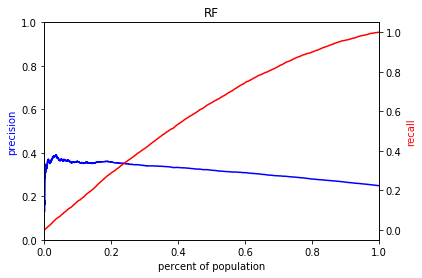

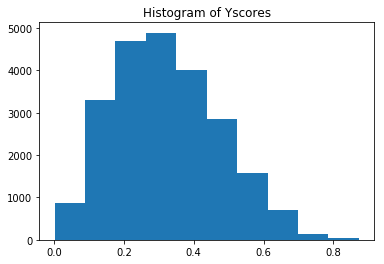

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.051494)
2. Feature total_price_including_optional_support_discrete_low (0.047092)
3. Feature total_price_including_optional_support_discrete_high (0.043049)
4. Feature female_teacher (0.032161)
5. Feature school_magnet (0.031389)
6. Feature secondary_focus_area_nan (0.030981)
7. Feature secondary_focus_area_Literacy & Language (0.028771)
8. Feature students_reached_discrete_med (0.028573)
9. Feature school_charter (0.027884)
10. Feature school_metro_urban (0.027350)

	Model 31
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

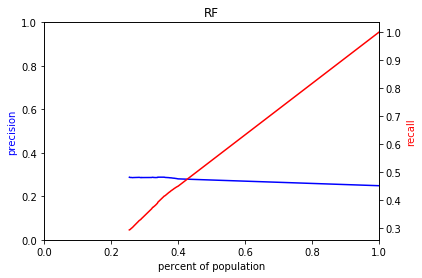

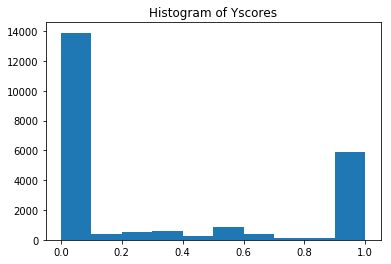

FEATURE IMPORTANCES

1. Feature secondary_focus_area_nan (0.046043)
2. Feature female_teacher (0.043985)
3. Feature total_price_including_optional_support_discrete_high (0.043740)
4. Feature poverty_level_highest poverty (0.041950)
5. Feature secondary_focus_area_Literacy & Language (0.038640)
6. Feature total_price_including_optional_support_discrete_low (0.037797)
7. Feature poverty_level_high poverty (0.036419)
8. Feature grade_level_Grades 3-5 (0.035475)
9. Feature total_price_including_optional_support_discrete_med (0.033706)
10. Feature school_charter (0.033185)

	Model 32
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

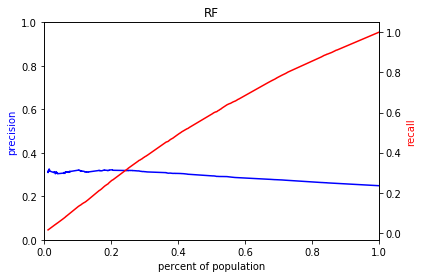

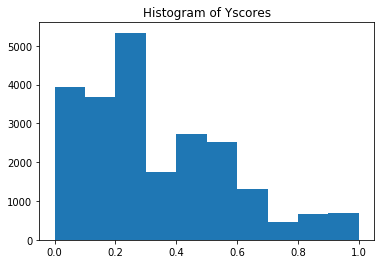

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.052922)
2. Feature female_teacher (0.046799)
3. Feature school_magnet (0.042475)
4. Feature secondary_focus_area_nan (0.038358)
5. Feature students_reached_discrete_med (0.032898)
6. Feature secondary_focus_area_Literacy & Language (0.032146)
7. Feature school_charter (0.031089)
8. Feature grade_level_Grades 3-5 (0.030689)
9. Feature students_reached_discrete_low (0.030630)
10. Feature total_price_including_optional_support_discrete_high (0.030436)

	Model 33
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesf

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

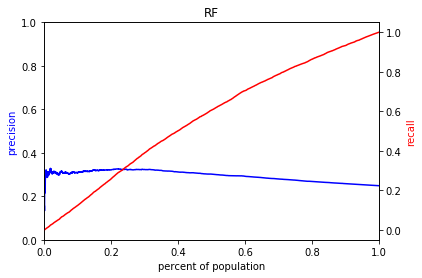

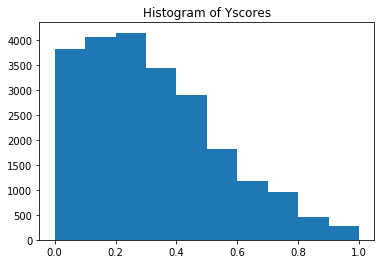

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.050197)
2. Feature female_teacher (0.043201)
3. Feature school_magnet (0.039308)
4. Feature secondary_focus_area_nan (0.035847)
5. Feature students_reached_discrete_med (0.032793)
6. Feature school_charter (0.032039)
7. Feature secondary_focus_area_Literacy & Language (0.031721)
8. Feature students_reached_discrete_low (0.031436)
9. Feature grade_level_Grades 3-5 (0.029719)
10. Feature students_reached_discrete_high (0.029612)

	Model 34
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predicted.
		Add

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

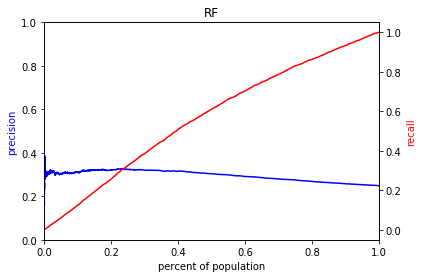

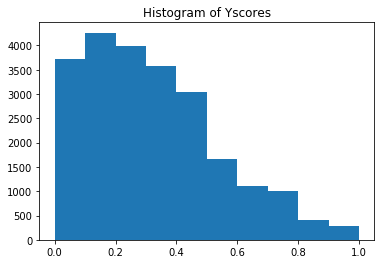

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.051371)
2. Feature female_teacher (0.043939)
3. Feature school_magnet (0.038999)
4. Feature secondary_focus_area_nan (0.036798)
5. Feature students_reached_discrete_med (0.033534)
6. Feature secondary_focus_area_Literacy & Language (0.032808)
7. Feature students_reached_discrete_low (0.031214)
8. Feature school_charter (0.030884)
9. Feature grade_level_Grades 3-5 (0.030242)
10. Feature students_reached_discrete_high (0.029590)

	Model 35
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predicted.
		Ad

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

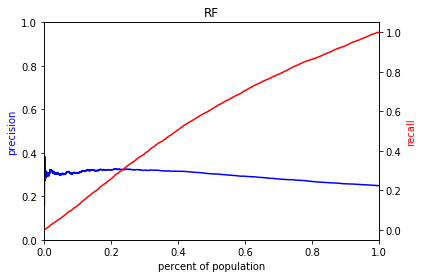

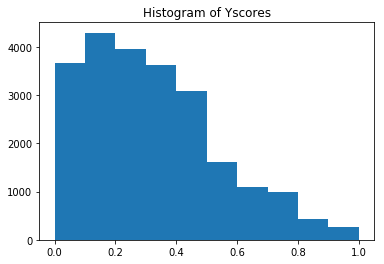

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.052092)
2. Feature female_teacher (0.043828)
3. Feature school_magnet (0.039116)
4. Feature secondary_focus_area_nan (0.036967)
5. Feature students_reached_discrete_med (0.033330)
6. Feature secondary_focus_area_Literacy & Language (0.032576)
7. Feature school_charter (0.031059)
8. Feature students_reached_discrete_low (0.030994)
9. Feature grade_level_Grades 3-5 (0.030230)
10. Feature students_reached_discrete_high (0.029256)

	Model 36
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predicted.
		Added

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

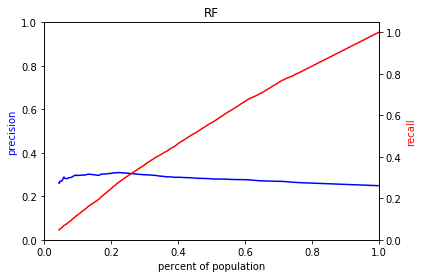

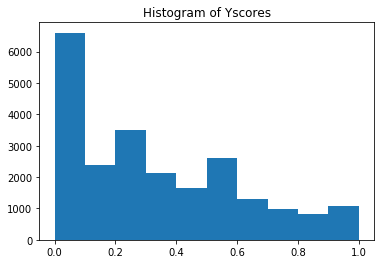

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.063756)
2. Feature total_price_including_optional_support_discrete_low (0.061247)
3. Feature eligible_double_your_impact_match (0.050138)
4. Feature secondary_focus_area_nan (0.037964)
5. Feature primary_focus_area_Literacy & Language (0.034119)
6. Feature secondary_focus_area_Math & Science (0.033225)
7. Feature female_teacher (0.032591)
8. Feature secondary_focus_area_Literacy & Language (0.031903)
9. Feature students_reached_discrete_med (0.030957)
10. Feature resource_type_Technology (0.029580)

	Model 37
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

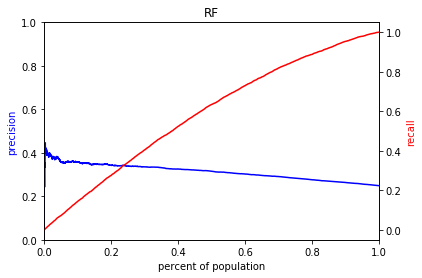

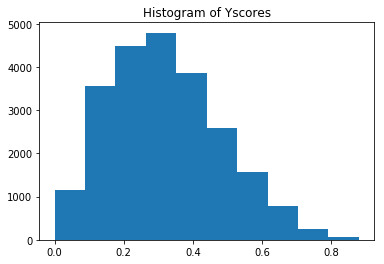

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.058276)
2. Feature total_price_including_optional_support_discrete_low (0.049631)
3. Feature total_price_including_optional_support_discrete_high (0.046950)
4. Feature secondary_focus_area_nan (0.030457)
5. Feature school_magnet (0.030111)
6. Feature students_reached_discrete_med (0.029917)
7. Feature female_teacher (0.029693)
8. Feature primary_focus_area_Literacy & Language (0.029615)
9. Feature resource_type_Technology (0.028607)
10. Feature students_reached_discrete_low (0.028243)

	Model 38
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

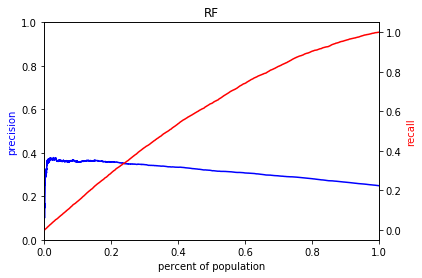

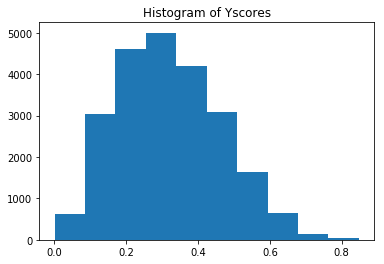

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.055434)
2. Feature total_price_including_optional_support_discrete_low (0.049783)
3. Feature total_price_including_optional_support_discrete_high (0.049201)
4. Feature female_teacher (0.032184)
5. Feature school_magnet (0.030625)
6. Feature secondary_focus_area_nan (0.030229)
7. Feature school_charter (0.028366)
8. Feature secondary_focus_area_Literacy & Language (0.028353)
9. Feature school_metro_urban (0.027385)
10. Feature students_reached_discrete_med (0.027312)

	Model 39
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trai

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

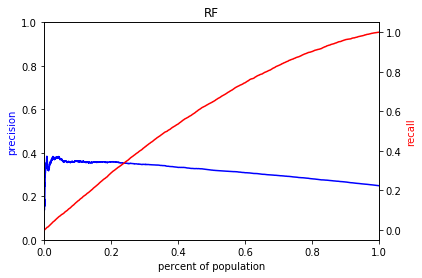

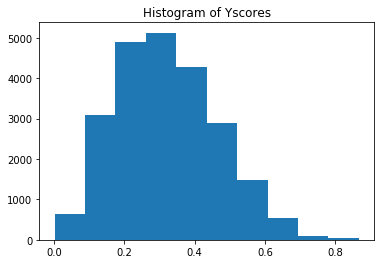

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.056035)
2. Feature total_price_including_optional_support_discrete_low (0.051065)
3. Feature total_price_including_optional_support_discrete_high (0.048125)
4. Feature female_teacher (0.031289)
5. Feature school_magnet (0.030662)
6. Feature secondary_focus_area_nan (0.030482)
7. Feature secondary_focus_area_Literacy & Language (0.028299)
8. Feature students_reached_discrete_med (0.027425)
9. Feature school_metro_urban (0.027418)
10. Feature resource_type_Technology (0.027236)

	Model 40
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succe

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

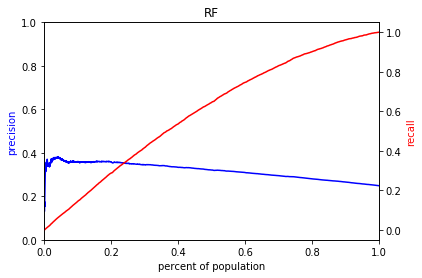

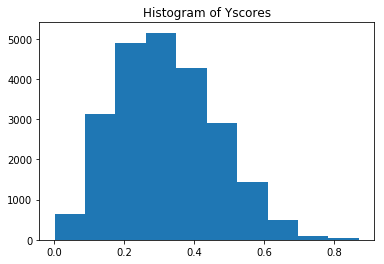

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.055679)
2. Feature total_price_including_optional_support_discrete_low (0.051412)
3. Feature total_price_including_optional_support_discrete_high (0.047727)
4. Feature female_teacher (0.031419)
5. Feature school_magnet (0.030790)
6. Feature secondary_focus_area_nan (0.030181)
7. Feature secondary_focus_area_Literacy & Language (0.028000)
8. Feature students_reached_discrete_med (0.027514)
9. Feature school_metro_urban (0.027420)
10. Feature resource_type_Technology (0.027234)


Working with:  RF

	Model 41
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

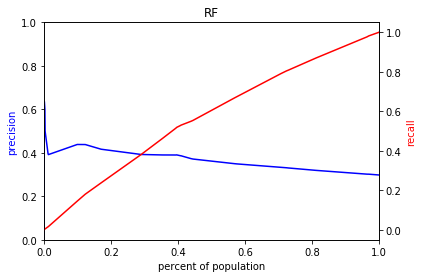

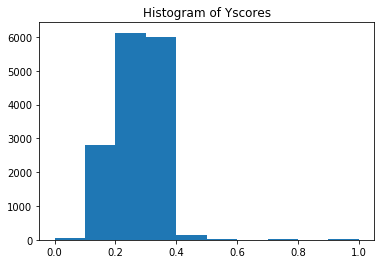

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.408823)
2. Feature resource_type_Technology (0.095419)
3. Feature total_price_including_optional_support_discrete_low (0.093236)
4. Feature resource_type_Books (0.082452)
5. Feature total_price_including_optional_support_discrete_top_outlier (0.070539)
6. Feature eligible_double_your_impact_match (0.048981)
7. Feature resource_type_Supplies (0.039590)
8. Feature poverty_level_highest poverty (0.038918)
9. Feature primary_focus_area_Literacy & Language (0.028771)
10. Feature school_metro_urban (0.023268)

	Model 42
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbos

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

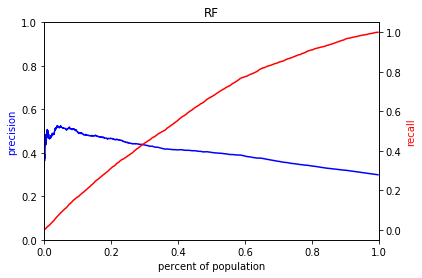

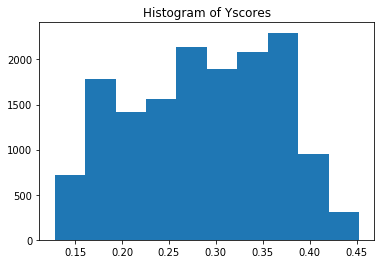

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.328198)
2. Feature total_price_including_optional_support_discrete_low (0.263774)
3. Feature total_price_including_optional_support_discrete_med (0.089817)
4. Feature eligible_double_your_impact_match (0.048003)
5. Feature school_metro_rural (0.031340)
6. Feature resource_type_Technology (0.030087)
7. Feature primary_focus_area_Literacy & Language (0.025811)
8. Feature school_metro_urban (0.023946)
9. Feature poverty_level_highest poverty (0.020580)
10. Feature resource_type_Supplies (0.020460)

	Model 43
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
   

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

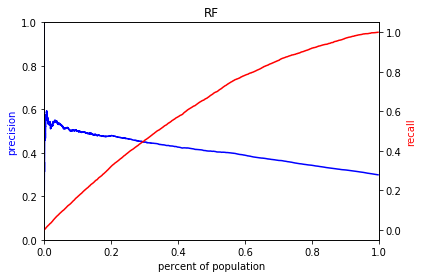

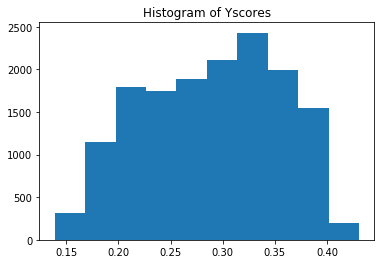

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.305938)
2. Feature total_price_including_optional_support_discrete_high (0.228845)
3. Feature eligible_double_your_impact_match (0.107106)
4. Feature resource_type_Technology (0.078941)
5. Feature total_price_including_optional_support_discrete_med (0.030007)
6. Feature total_price_including_optional_support_discrete_bottom_outlier (0.022516)
7. Feature school_metro_urban (0.021010)
8. Feature poverty_level_highest poverty (0.020490)
9. Feature resource_type_Books (0.019763)
10. Feature resource_type_Trips (0.019094)

	Model 44
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_sta

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

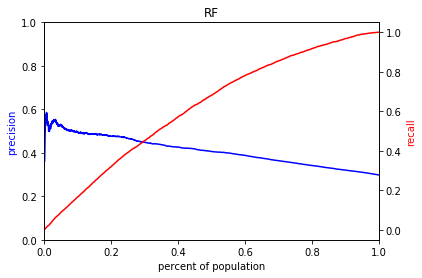

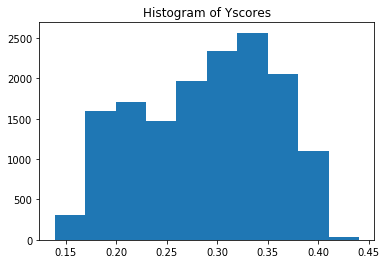

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.319212)
2. Feature total_price_including_optional_support_discrete_high (0.213992)
3. Feature eligible_double_your_impact_match (0.095315)
4. Feature resource_type_Technology (0.072816)
5. Feature total_price_including_optional_support_discrete_med (0.039303)
6. Feature school_metro_urban (0.024969)
7. Feature total_price_including_optional_support_discrete_bottom_outlier (0.022737)
8. Feature school_metro_rural (0.020970)
9. Feature primary_focus_area_Literacy & Language (0.019275)
10. Feature poverty_level_highest poverty (0.019250)

	Model 45
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_scor

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

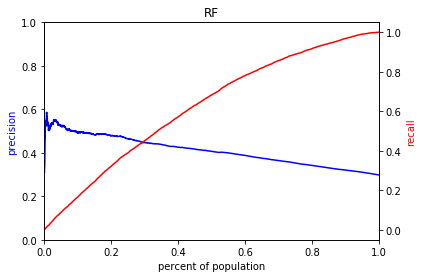

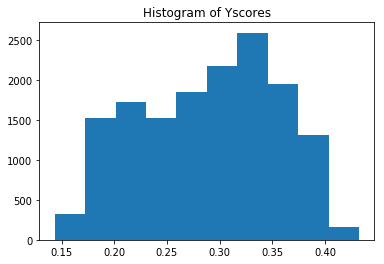

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.312637)
2. Feature total_price_including_optional_support_discrete_high (0.215087)
3. Feature eligible_double_your_impact_match (0.099366)
4. Feature resource_type_Technology (0.072244)
5. Feature total_price_including_optional_support_discrete_med (0.037978)
6. Feature school_metro_urban (0.023409)
7. Feature total_price_including_optional_support_discrete_bottom_outlier (0.023116)
8. Feature resource_type_Books (0.020978)
9. Feature school_metro_rural (0.020714)
10. Feature primary_focus_area_Literacy & Language (0.019314)

	Model 46
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, rand

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

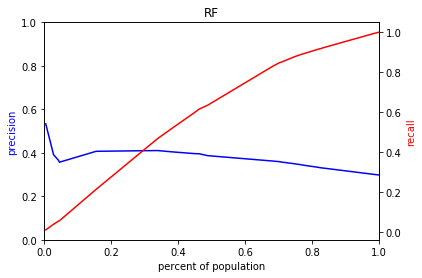

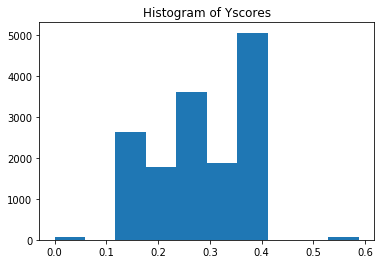

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.653588)
2. Feature total_price_including_optional_support_discrete_high (0.135056)
3. Feature total_price_including_optional_support_discrete_bottom_outlier (0.058527)
4. Feature poverty_level_high poverty (0.028443)
5. Feature eligible_double_your_impact_match (0.023061)
6. Feature school_metro_rural (0.021720)
7. Feature poverty_level_highest poverty (0.014730)
8. Feature primary_focus_area_Math & Science (0.014583)
9. Feature poverty_level_moderate poverty (0.009370)
10. Feature school_metro_urban (0.007189)

	Model 47
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

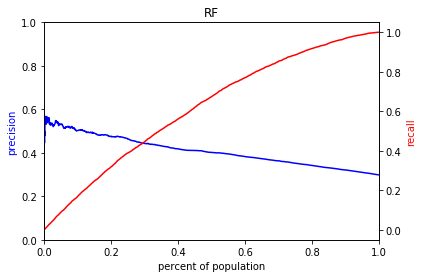

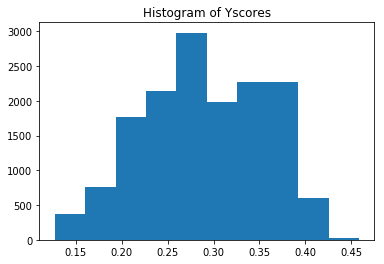

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.299863)
2. Feature total_price_including_optional_support_discrete_low (0.186176)
3. Feature eligible_double_your_impact_match (0.111098)
4. Feature total_price_including_optional_support_discrete_med (0.087239)
5. Feature resource_type_Trips (0.039070)
6. Feature resource_type_Technology (0.032541)
7. Feature total_price_including_optional_support_discrete_bottom_outlier (0.024801)
8. Feature resource_type_Books (0.023536)
9. Feature primary_focus_area_Literacy & Language (0.021639)
10. Feature total_price_including_optional_support_discrete_top_outlier (0.019599)

	Model 48
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

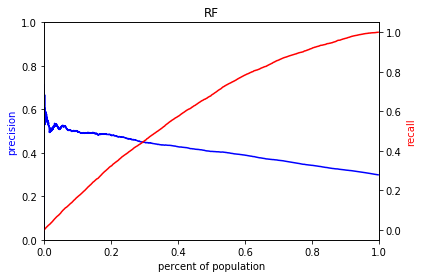

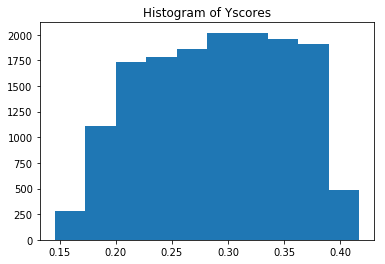

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.277143)
2. Feature total_price_including_optional_support_discrete_high (0.241033)
3. Feature eligible_double_your_impact_match (0.112649)
4. Feature resource_type_Technology (0.059639)
5. Feature total_price_including_optional_support_discrete_med (0.045502)
6. Feature school_metro_urban (0.022678)
7. Feature resource_type_Trips (0.021603)
8. Feature total_price_including_optional_support_discrete_bottom_outlier (0.021527)
9. Feature resource_type_Books (0.019699)
10. Feature school_metro_rural (0.018941)

	Model 49
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, v

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

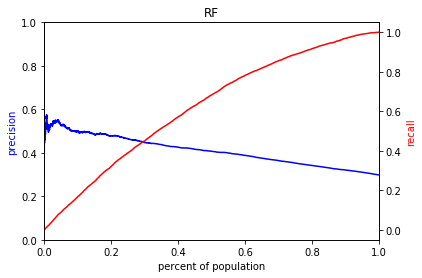

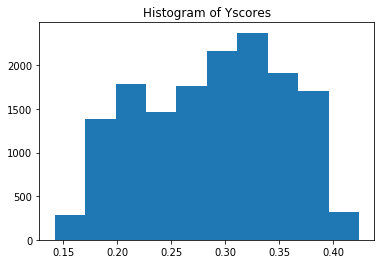

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.306719)
2. Feature total_price_including_optional_support_discrete_high (0.229351)
3. Feature eligible_double_your_impact_match (0.101676)
4. Feature resource_type_Technology (0.066632)
5. Feature total_price_including_optional_support_discrete_med (0.040711)
6. Feature school_metro_urban (0.023011)
7. Feature resource_type_Books (0.020633)
8. Feature total_price_including_optional_support_discrete_bottom_outlier (0.020487)
9. Feature school_metro_rural (0.020264)
10. Feature primary_focus_area_Literacy & Language (0.018749)

	Model 50
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

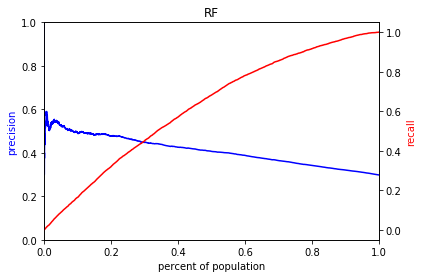

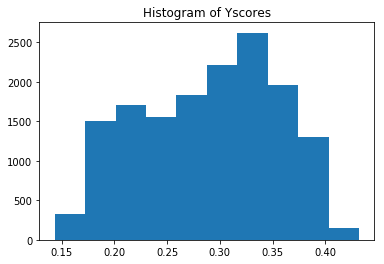

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.310783)
2. Feature total_price_including_optional_support_discrete_high (0.214498)
3. Feature eligible_double_your_impact_match (0.099445)
4. Feature resource_type_Technology (0.073971)
5. Feature total_price_including_optional_support_discrete_med (0.037946)
6. Feature school_metro_urban (0.023820)
7. Feature total_price_including_optional_support_discrete_bottom_outlier (0.023269)
8. Feature resource_type_Books (0.020907)
9. Feature school_metro_rural (0.020313)
10. Feature primary_focus_area_Literacy & Language (0.019730)

	Model 51
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, rando

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

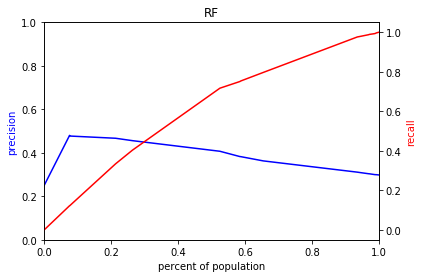

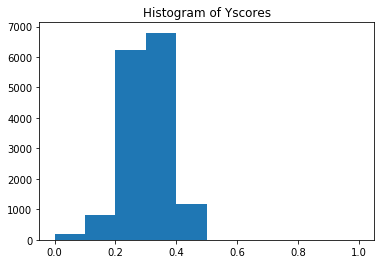

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.419784)
2. Feature eligible_double_your_impact_match (0.201650)
3. Feature total_price_including_optional_support_discrete_med (0.198549)
4. Feature resource_type_Trips (0.047557)
5. Feature resource_type_Supplies (0.029739)
6. Feature total_price_including_optional_support_discrete_bottom_outlier (0.026932)
7. Feature primary_focus_area_Literacy & Language (0.019896)
8. Feature students_reached_discrete_high (0.014581)
9. Feature primary_focus_area_Music & The Arts (0.010860)
10. Feature secondary_focus_area_Math & Science (0.007731)

	Model 52
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

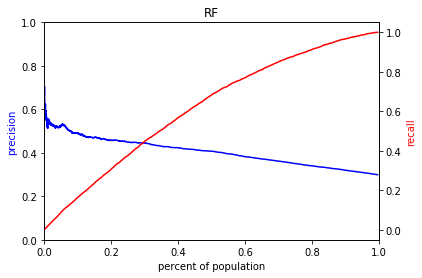

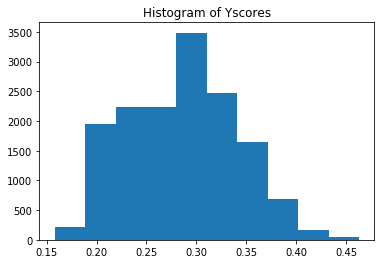

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.328677)
2. Feature total_price_including_optional_support_discrete_high (0.215271)
3. Feature eligible_double_your_impact_match (0.062385)
4. Feature resource_type_Technology (0.043615)
5. Feature total_price_including_optional_support_discrete_med (0.041924)
6. Feature school_metro_rural (0.041199)
7. Feature primary_focus_area_Literacy & Language (0.036302)
8. Feature total_price_including_optional_support_discrete_bottom_outlier (0.032294)
9. Feature poverty_level_highest poverty (0.030582)
10. Feature resource_type_Books (0.019814)

	Model 53
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

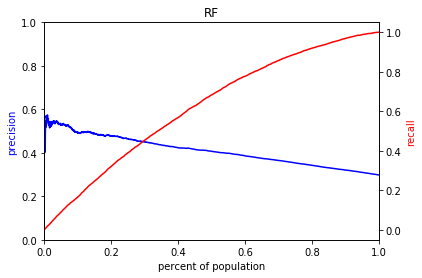

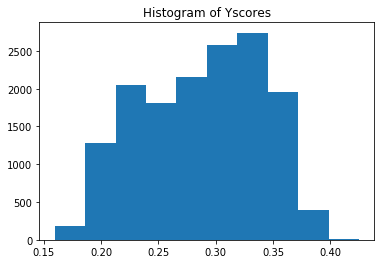

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.273338)
2. Feature total_price_including_optional_support_discrete_high (0.218408)
3. Feature eligible_double_your_impact_match (0.102669)
4. Feature resource_type_Technology (0.065919)
5. Feature resource_type_Books (0.034020)
6. Feature total_price_including_optional_support_discrete_bottom_outlier (0.028465)
7. Feature total_price_including_optional_support_discrete_med (0.024787)
8. Feature school_metro_urban (0.024089)
9. Feature primary_focus_area_Literacy & Language (0.022537)
10. Feature school_metro_rural (0.021624)

	Model 54
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, ra

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

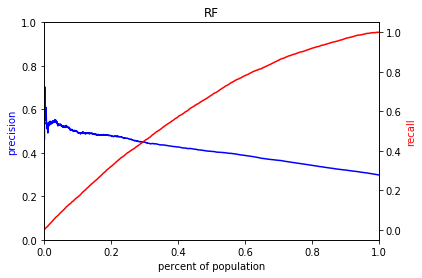

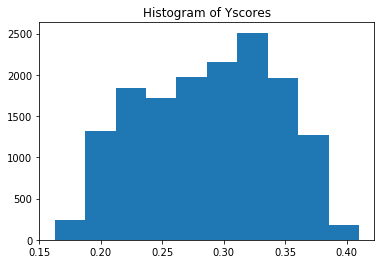

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.281488)
2. Feature total_price_including_optional_support_discrete_high (0.212256)
3. Feature eligible_double_your_impact_match (0.099301)
4. Feature resource_type_Technology (0.074627)
5. Feature total_price_including_optional_support_discrete_med (0.030422)
6. Feature resource_type_Books (0.026594)
7. Feature school_metro_urban (0.025509)
8. Feature total_price_including_optional_support_discrete_bottom_outlier (0.025173)
9. Feature school_metro_rural (0.023981)
10. Feature total_price_including_optional_support_discrete_top_outlier (0.022575)

	Model 55
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
         

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

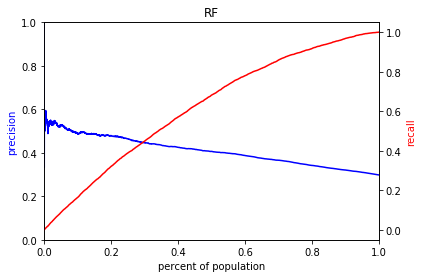

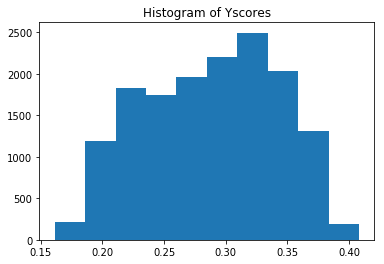

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.282713)
2. Feature total_price_including_optional_support_discrete_high (0.208956)
3. Feature eligible_double_your_impact_match (0.099026)
4. Feature resource_type_Technology (0.080037)
5. Feature total_price_including_optional_support_discrete_med (0.028308)
6. Feature school_metro_urban (0.026002)
7. Feature resource_type_Books (0.025638)
8. Feature total_price_including_optional_support_discrete_bottom_outlier (0.024461)
9. Feature school_metro_rural (0.023048)
10. Feature poverty_level_highest poverty (0.021122)

	Model 56
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

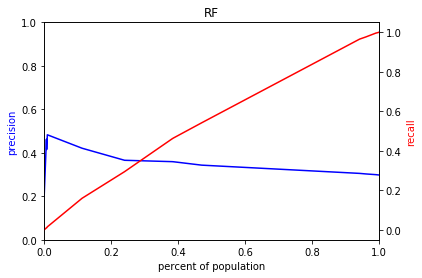

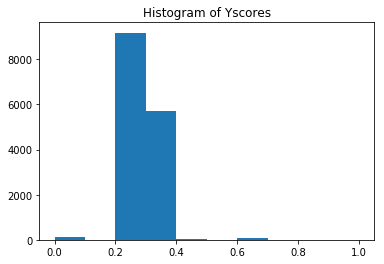

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.207078)
2. Feature total_price_including_optional_support_discrete_bottom_outlier (0.159691)
3. Feature total_price_including_optional_support_discrete_top_outlier (0.154102)
4. Feature school_metro_nan (0.150019)
5. Feature school_metro_rural (0.124329)
6. Feature primary_focus_area_Applied Learning (0.050902)
7. Feature poverty_level_low poverty (0.031304)
8. Feature resource_type_Supplies (0.019529)
9. Feature school_charter (0.017292)
10. Feature resource_type_Books (0.013277)

	Model 57
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succ

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

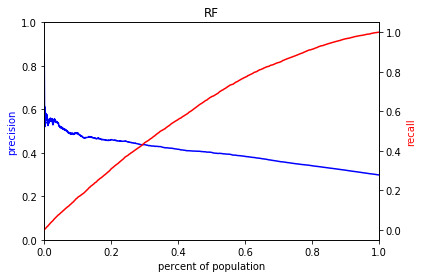

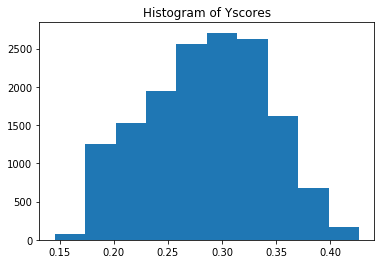

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.235923)
2. Feature total_price_including_optional_support_discrete_low (0.220621)
3. Feature resource_type_Technology (0.097646)
4. Feature eligible_double_your_impact_match (0.075855)
5. Feature total_price_including_optional_support_discrete_med (0.053329)
6. Feature school_metro_rural (0.043063)
7. Feature school_metro_urban (0.035690)
8. Feature resource_type_Trips (0.025041)
9. Feature resource_type_Books (0.023188)
10. Feature total_price_including_optional_support_discrete_bottom_outlier (0.022986)

	Model 58
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, ve

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

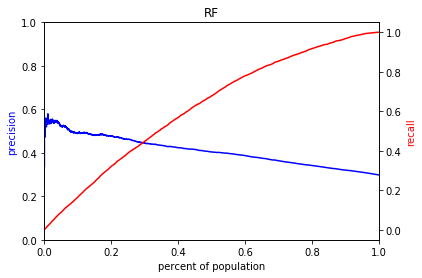

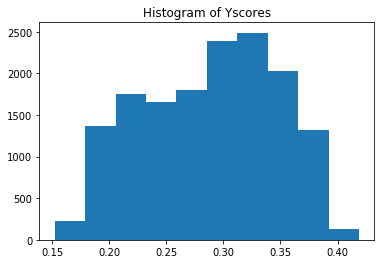

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.323545)
2. Feature total_price_including_optional_support_discrete_high (0.209146)
3. Feature eligible_double_your_impact_match (0.096484)
4. Feature resource_type_Technology (0.077538)
5. Feature total_price_including_optional_support_discrete_med (0.026602)
6. Feature school_metro_rural (0.024428)
7. Feature school_metro_urban (0.022653)
8. Feature resource_type_Books (0.019721)
9. Feature total_price_including_optional_support_discrete_bottom_outlier (0.019235)
10. Feature poverty_level_highest poverty (0.018630)

	Model 59
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_sta

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

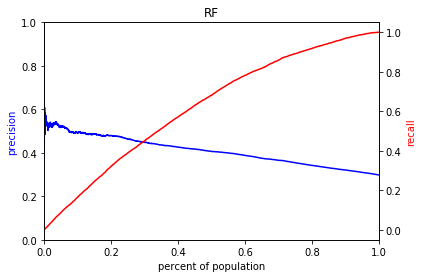

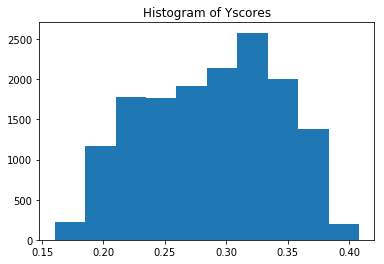

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.277606)
2. Feature total_price_including_optional_support_discrete_high (0.214705)
3. Feature eligible_double_your_impact_match (0.109135)
4. Feature resource_type_Technology (0.076220)
5. Feature total_price_including_optional_support_discrete_med (0.031355)
6. Feature total_price_including_optional_support_discrete_bottom_outlier (0.025064)
7. Feature resource_type_Books (0.024950)
8. Feature school_metro_rural (0.023543)
9. Feature school_metro_urban (0.022541)
10. Feature poverty_level_highest poverty (0.021574)

	Model 60
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_st

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

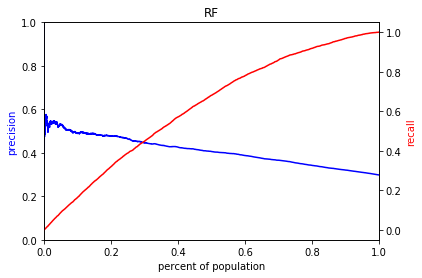

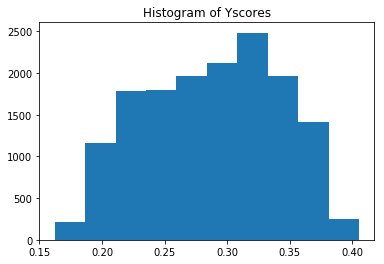

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.275680)
2. Feature total_price_including_optional_support_discrete_high (0.214707)
3. Feature eligible_double_your_impact_match (0.101042)
4. Feature resource_type_Technology (0.078171)
5. Feature total_price_including_optional_support_discrete_med (0.028676)
6. Feature school_metro_urban (0.026230)
7. Feature resource_type_Books (0.025735)
8. Feature total_price_including_optional_support_discrete_bottom_outlier (0.025130)
9. Feature school_metro_rural (0.023174)
10. Feature poverty_level_highest poverty (0.021129)

	Model 61
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

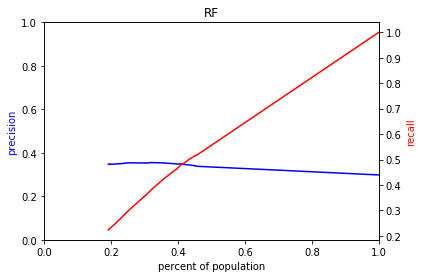

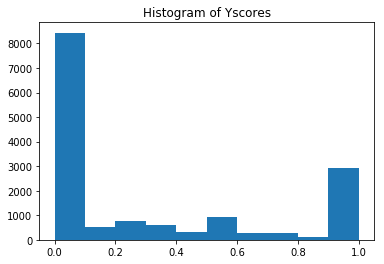

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.068860)
2. Feature female_teacher (0.047600)
3. Feature school_charter (0.045749)
4. Feature school_magnet (0.040240)
5. Feature grade_level_Grades 3-5 (0.039980)
6. Feature total_price_including_optional_support_discrete_high (0.035851)
7. Feature students_reached_discrete_low (0.034979)
8. Feature grade_level_Grades PreK-2 (0.031630)
9. Feature students_reached_discrete_high (0.029597)
10. Feature grade_level_Grades 6-8 (0.029282)

	Model 62
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predicted.
	

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

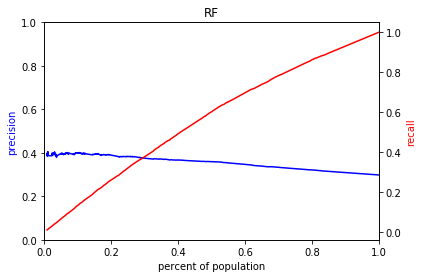

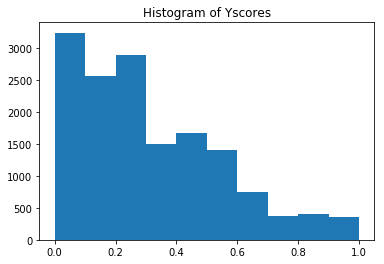

FEATURE IMPORTANCES

1. Feature female_teacher (0.046744)
2. Feature school_magnet (0.040201)
3. Feature school_charter (0.037350)
4. Feature secondary_focus_area_nan (0.036304)
5. Feature grade_level_Grades 3-5 (0.035392)
6. Feature students_reached_discrete_med (0.034208)
7. Feature students_reached_discrete_low (0.033963)
8. Feature eligible_double_your_impact_match (0.033818)
9. Feature total_price_including_optional_support_discrete_low (0.033308)
10. Feature students_reached_discrete_high (0.032441)

	Model 63
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predic

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

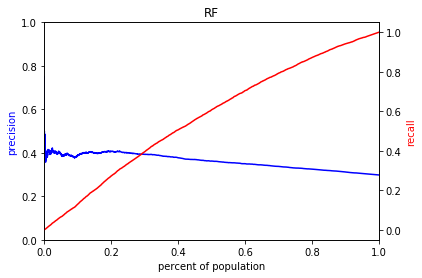

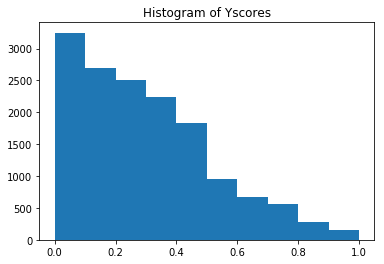

FEATURE IMPORTANCES

1. Feature female_teacher (0.045563)
2. Feature school_magnet (0.039952)
3. Feature eligible_double_your_impact_match (0.039398)
4. Feature secondary_focus_area_nan (0.038883)
5. Feature school_charter (0.037868)
6. Feature students_reached_discrete_med (0.034639)
7. Feature grade_level_Grades 3-5 (0.033877)
8. Feature secondary_focus_area_Literacy & Language (0.033669)
9. Feature students_reached_discrete_low (0.033022)
10. Feature students_reached_discrete_high (0.030984)

	Model 64
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predicted.
		Add

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

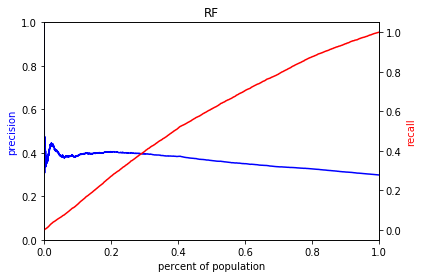

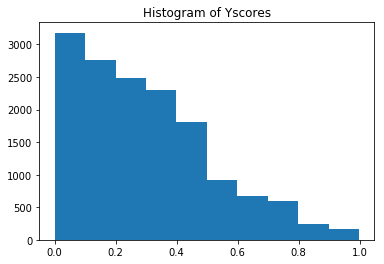

FEATURE IMPORTANCES

1. Feature female_teacher (0.045646)
2. Feature eligible_double_your_impact_match (0.040444)
3. Feature school_magnet (0.039709)
4. Feature secondary_focus_area_nan (0.038835)
5. Feature school_charter (0.038613)
6. Feature students_reached_discrete_med (0.034661)
7. Feature grade_level_Grades 3-5 (0.033547)
8. Feature students_reached_discrete_low (0.033271)
9. Feature secondary_focus_area_Literacy & Language (0.032720)
10. Feature students_reached_discrete_high (0.031243)

	Model 65
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predicted.
		Ad

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

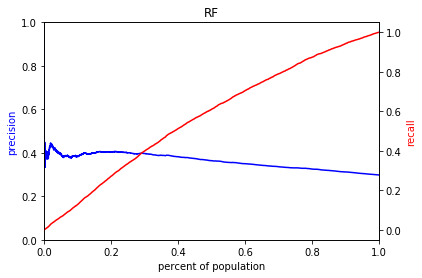

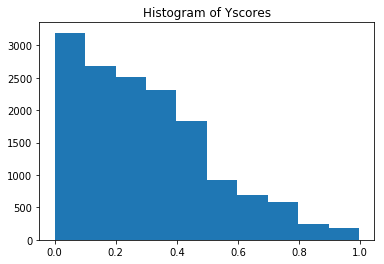

FEATURE IMPORTANCES

1. Feature female_teacher (0.045350)
2. Feature eligible_double_your_impact_match (0.040742)
3. Feature school_magnet (0.039807)
4. Feature secondary_focus_area_nan (0.038769)
5. Feature school_charter (0.038371)
6. Feature students_reached_discrete_med (0.034832)
7. Feature grade_level_Grades 3-5 (0.033581)
8. Feature students_reached_discrete_low (0.033260)
9. Feature secondary_focus_area_Literacy & Language (0.032867)
10. Feature students_reached_discrete_high (0.031464)

	Model 66
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predicted.
		Added

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

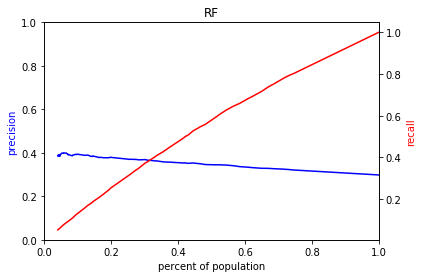

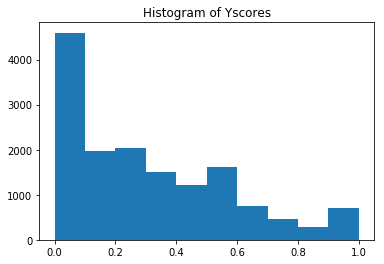

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.071157)
2. Feature eligible_double_your_impact_match (0.041435)
3. Feature female_teacher (0.038613)
4. Feature school_charter (0.036605)
5. Feature school_magnet (0.035770)
6. Feature secondary_focus_area_Literacy & Language (0.032965)
7. Feature grade_level_Grades PreK-2 (0.032430)
8. Feature secondary_focus_area_nan (0.032083)
9. Feature poverty_level_highest poverty (0.032024)
10. Feature secondary_focus_area_Math & Science (0.031823)

	Model 67
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
	

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

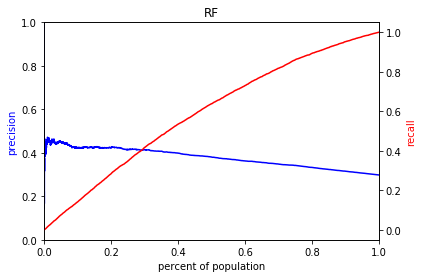

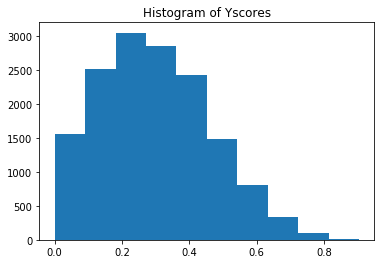

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.064009)
2. Feature female_teacher (0.036462)
3. Feature school_charter (0.035850)
4. Feature total_price_including_optional_support_discrete_high (0.035231)
5. Feature eligible_double_your_impact_match (0.034024)
6. Feature secondary_focus_area_nan (0.032692)
7. Feature school_magnet (0.032531)
8. Feature grade_level_Grades PreK-2 (0.029509)
9. Feature secondary_focus_area_Literacy & Language (0.029081)
10. Feature students_reached_discrete_med (0.028331)

	Model 68
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfull

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

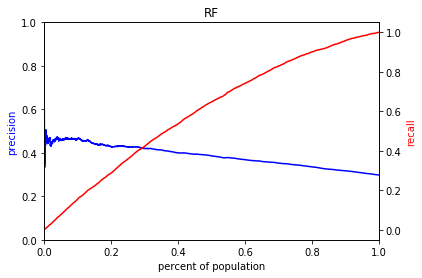

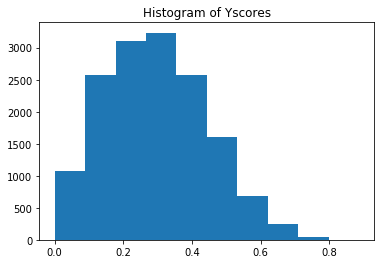

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.055352)
2. Feature eligible_double_your_impact_match (0.040443)
3. Feature total_price_including_optional_support_discrete_high (0.040080)
4. Feature female_teacher (0.034411)
5. Feature school_charter (0.033458)
6. Feature school_magnet (0.033089)
7. Feature secondary_focus_area_nan (0.031974)
8. Feature students_reached_discrete_med (0.029311)
9. Feature secondary_focus_area_Literacy & Language (0.028902)
10. Feature students_reached_discrete_low (0.028764)

	Model 69
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succe

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

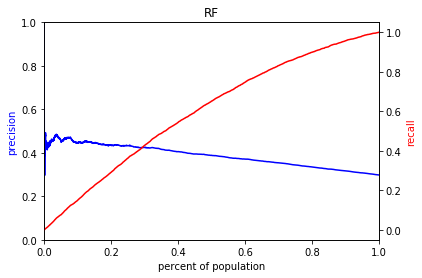

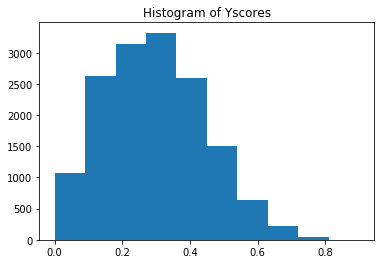

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.054793)
2. Feature total_price_including_optional_support_discrete_high (0.040165)
3. Feature eligible_double_your_impact_match (0.038979)
4. Feature female_teacher (0.034050)
5. Feature school_magnet (0.033823)
6. Feature school_charter (0.033736)
7. Feature secondary_focus_area_nan (0.031635)
8. Feature secondary_focus_area_Literacy & Language (0.029110)
9. Feature students_reached_discrete_med (0.028988)
10. Feature students_reached_discrete_low (0.028960)

	Model 70
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succ

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

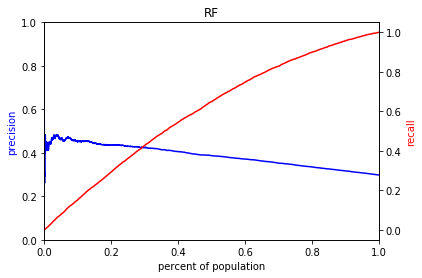

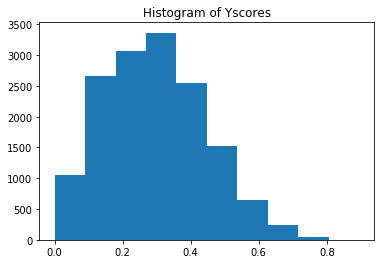

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.054260)
2. Feature total_price_including_optional_support_discrete_high (0.040553)
3. Feature eligible_double_your_impact_match (0.038923)
4. Feature female_teacher (0.034209)
5. Feature school_magnet (0.033791)
6. Feature school_charter (0.033424)
7. Feature secondary_focus_area_nan (0.031790)
8. Feature students_reached_discrete_med (0.029218)
9. Feature secondary_focus_area_Literacy & Language (0.029178)
10. Feature students_reached_discrete_low (0.029094)

	Model 71
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesful

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

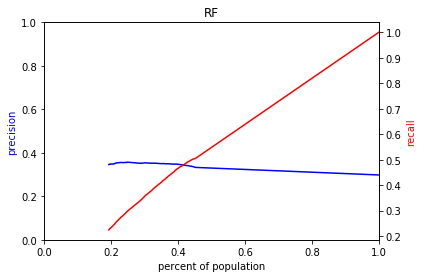

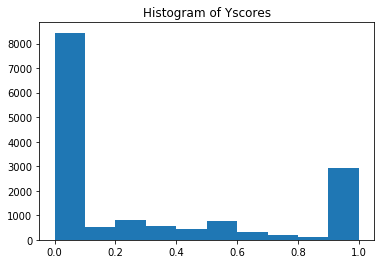

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.055649)
2. Feature female_teacher (0.049503)
3. Feature total_price_including_optional_support_discrete_low (0.047377)
4. Feature school_charter (0.042370)
5. Feature poverty_level_highest poverty (0.042035)
6. Feature poverty_level_high poverty (0.037777)
7. Feature school_metro_urban (0.036329)
8. Feature school_metro_suburban (0.036001)
9. Feature school_magnet (0.034779)
10. Feature secondary_focus_area_Literacy & Language (0.033237)

	Model 72
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predict

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

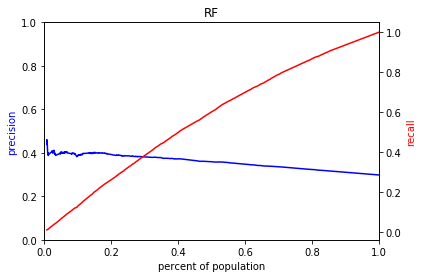

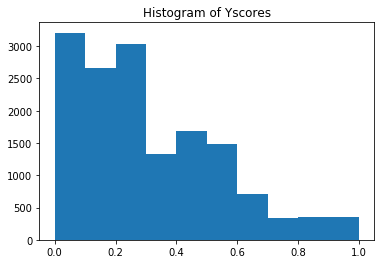

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.052837)
2. Feature secondary_focus_area_nan (0.038672)
3. Feature school_magnet (0.038550)
4. Feature female_teacher (0.036836)
5. Feature students_reached_discrete_med (0.036443)
6. Feature secondary_focus_area_Literacy & Language (0.034821)
7. Feature school_charter (0.034658)
8. Feature students_reached_discrete_low (0.034223)
9. Feature grade_level_Grades 3-5 (0.033280)
10. Feature students_reached_discrete_high (0.031512)

	Model 73
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predicted.
		Adde

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

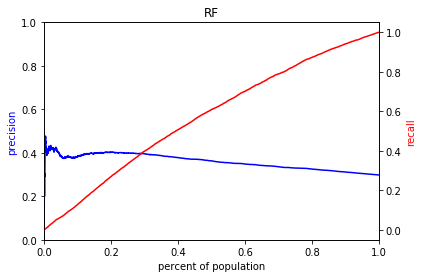

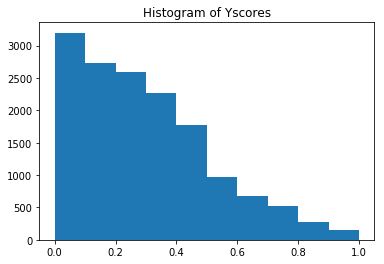

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.050449)
2. Feature female_teacher (0.043848)
3. Feature school_magnet (0.039883)
4. Feature secondary_focus_area_nan (0.038092)
5. Feature school_charter (0.036846)
6. Feature students_reached_discrete_med (0.033964)
7. Feature secondary_focus_area_Literacy & Language (0.032989)
8. Feature grade_level_Grades 3-5 (0.032929)
9. Feature students_reached_discrete_low (0.031793)
10. Feature total_price_including_optional_support_discrete_low (0.031616)

	Model 74
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesf

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

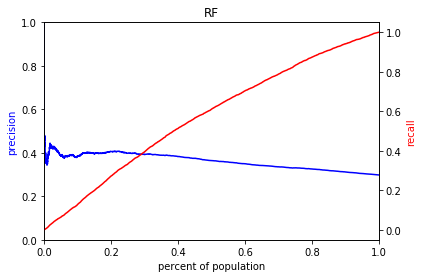

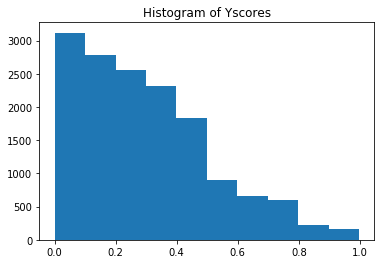

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.048978)
2. Feature female_teacher (0.044046)
3. Feature school_magnet (0.038778)
4. Feature secondary_focus_area_nan (0.037625)
5. Feature school_charter (0.036990)
6. Feature students_reached_discrete_med (0.033464)
7. Feature total_price_including_optional_support_discrete_low (0.031858)
8. Feature grade_level_Grades 3-5 (0.031690)
9. Feature secondary_focus_area_Literacy & Language (0.031671)
10. Feature students_reached_discrete_low (0.031596)

	Model 75
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succes

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

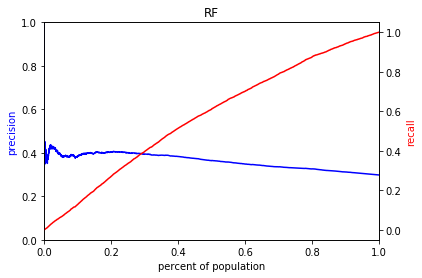

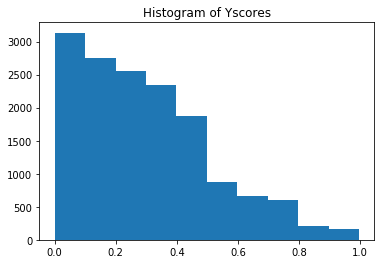

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.048770)
2. Feature female_teacher (0.044395)
3. Feature school_magnet (0.039074)
4. Feature secondary_focus_area_nan (0.037627)
5. Feature school_charter (0.036838)
6. Feature students_reached_discrete_med (0.033314)
7. Feature grade_level_Grades 3-5 (0.031986)
8. Feature students_reached_discrete_low (0.031821)
9. Feature secondary_focus_area_Literacy & Language (0.031771)
10. Feature total_price_including_optional_support_discrete_low (0.031168)

	Model 76
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesful

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

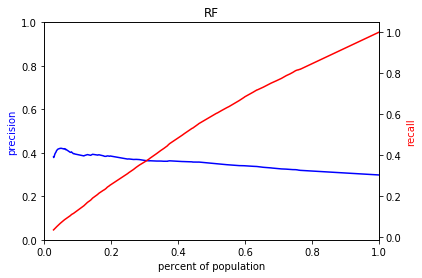

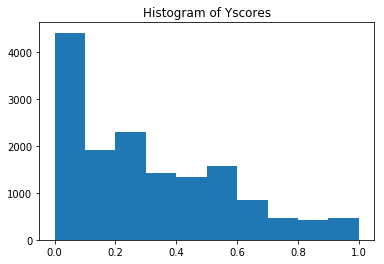

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.056818)
2. Feature total_price_including_optional_support_discrete_low (0.052524)
3. Feature school_magnet (0.038310)
4. Feature school_charter (0.035620)
5. Feature grade_level_Grades 3-5 (0.035576)
6. Feature resource_type_Technology (0.033573)
7. Feature students_reached_discrete_low (0.032646)
8. Feature secondary_focus_area_nan (0.032183)
9. Feature female_teacher (0.030173)
10. Feature poverty_level_highest poverty (0.030015)

	Model 77
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succe

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

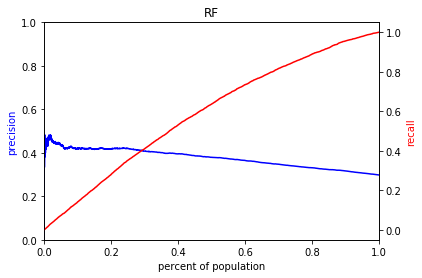

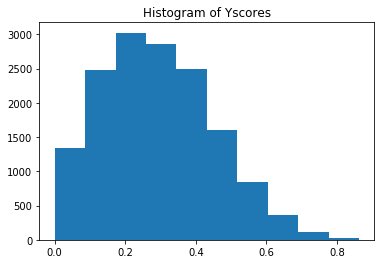

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.060442)
2. Feature total_price_including_optional_support_discrete_high (0.041404)
3. Feature eligible_double_your_impact_match (0.039105)
4. Feature school_charter (0.035141)
5. Feature female_teacher (0.033271)
6. Feature school_magnet (0.031487)
7. Feature secondary_focus_area_nan (0.030024)
8. Feature secondary_focus_area_Literacy & Language (0.028479)
9. Feature school_metro_urban (0.028363)
10. Feature resource_type_Technology (0.027776)

	Model 78
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained mo

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

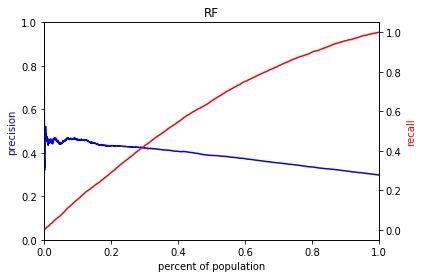

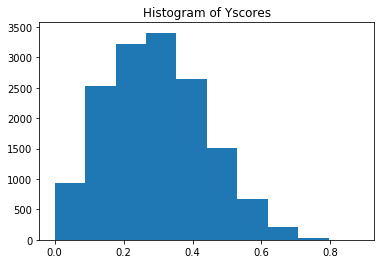

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.055576)
2. Feature total_price_including_optional_support_discrete_high (0.047859)
3. Feature eligible_double_your_impact_match (0.041238)
4. Feature school_magnet (0.033691)
5. Feature female_teacher (0.033070)
6. Feature school_charter (0.032087)
7. Feature secondary_focus_area_nan (0.030953)
8. Feature students_reached_discrete_med (0.027876)
9. Feature students_reached_discrete_low (0.027567)
10. Feature grade_level_Grades 3-5 (0.027434)

	Model 79
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained mod

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

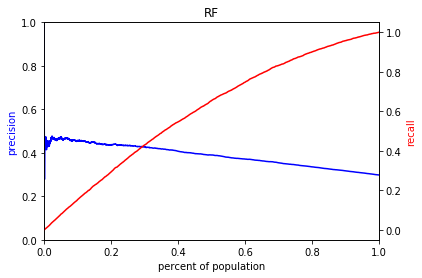

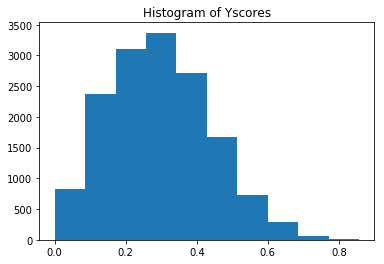

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.055936)
2. Feature total_price_including_optional_support_discrete_high (0.046984)
3. Feature eligible_double_your_impact_match (0.043548)
4. Feature female_teacher (0.033302)
5. Feature school_magnet (0.033130)
6. Feature school_charter (0.032000)
7. Feature secondary_focus_area_nan (0.030918)
8. Feature secondary_focus_area_Literacy & Language (0.028442)
9. Feature students_reached_discrete_low (0.027873)
10. Feature students_reached_discrete_med (0.027771)

	Model 80
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succ

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

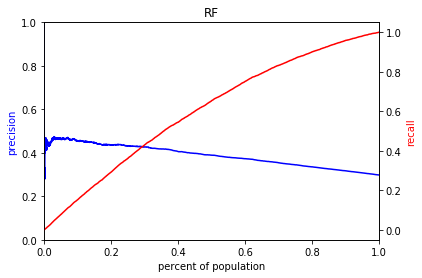

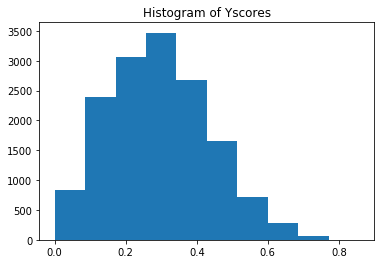

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.057863)
2. Feature total_price_including_optional_support_discrete_high (0.045753)
3. Feature eligible_double_your_impact_match (0.043950)
4. Feature female_teacher (0.033112)
5. Feature school_magnet (0.033041)
6. Feature school_charter (0.032153)
7. Feature secondary_focus_area_nan (0.030738)
8. Feature secondary_focus_area_Literacy & Language (0.028227)
9. Feature students_reached_discrete_low (0.028032)
10. Feature students_reached_discrete_med (0.028008)


Working with:  RF

	Model 81
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

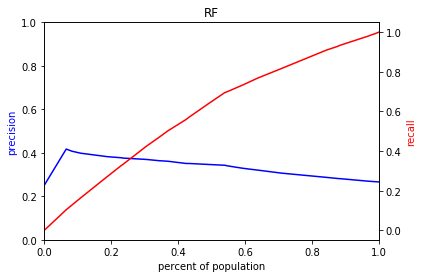

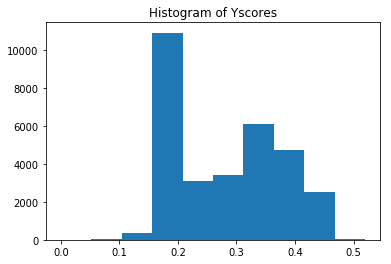

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.398501)
2. Feature total_price_including_optional_support_discrete_low (0.260349)
3. Feature total_price_including_optional_support_discrete_med (0.078999)
4. Feature school_metro_urban (0.067546)
5. Feature eligible_double_your_impact_match (0.044944)
6. Feature resource_type_Supplies (0.043411)
7. Feature primary_focus_area_Literacy & Language (0.029701)
8. Feature poverty_level_highest poverty (0.028423)
9. Feature primary_focus_area_Applied Learning (0.010935)
10. Feature resource_type_Trips (0.008439)

	Model 82
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, ver

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

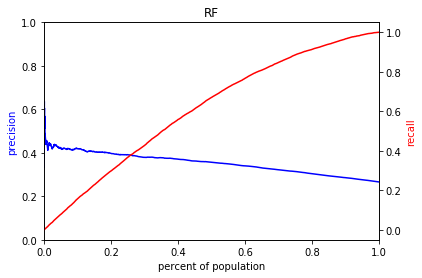

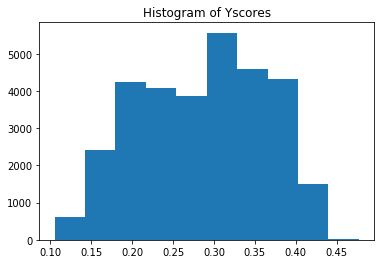

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.345730)
2. Feature total_price_including_optional_support_discrete_high (0.208811)
3. Feature eligible_double_your_impact_match (0.127001)
4. Feature total_price_including_optional_support_discrete_med (0.056253)
5. Feature school_metro_urban (0.043007)
6. Feature resource_type_Technology (0.035142)
7. Feature resource_type_Books (0.031117)
8. Feature total_price_including_optional_support_discrete_top_outlier (0.019681)
9. Feature poverty_level_highest poverty (0.018991)
10. Feature school_metro_rural (0.018984)

	Model 83
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=No

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

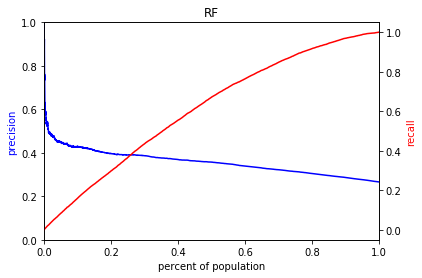

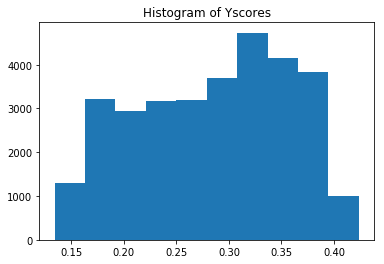

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.303823)
2. Feature total_price_including_optional_support_discrete_high (0.227936)
3. Feature eligible_double_your_impact_match (0.121413)
4. Feature resource_type_Technology (0.070836)
5. Feature total_price_including_optional_support_discrete_med (0.054065)
6. Feature school_metro_urban (0.024691)
7. Feature total_price_including_optional_support_discrete_bottom_outlier (0.019642)
8. Feature school_metro_rural (0.019167)
9. Feature resource_type_Books (0.017579)
10. Feature primary_focus_area_Math & Science (0.017275)

	Model 84
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

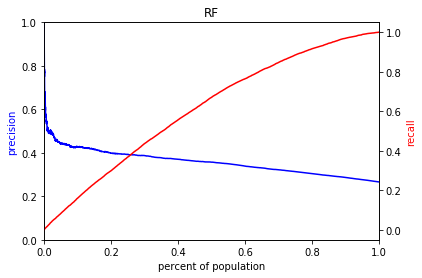

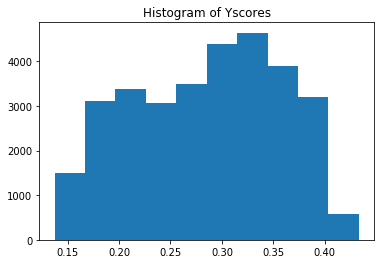

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.310615)
2. Feature total_price_including_optional_support_discrete_high (0.227822)
3. Feature eligible_double_your_impact_match (0.122074)
4. Feature resource_type_Technology (0.072297)
5. Feature total_price_including_optional_support_discrete_med (0.039269)
6. Feature school_metro_urban (0.025542)
7. Feature school_metro_rural (0.022385)
8. Feature resource_type_Books (0.020310)
9. Feature primary_focus_area_Math & Science (0.017173)
10. Feature primary_focus_area_Literacy & Language (0.017145)

	Model 85
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

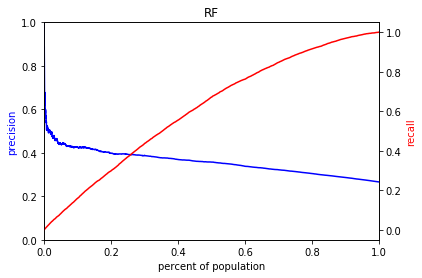

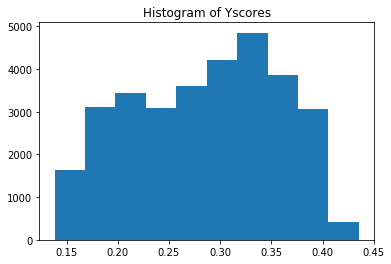

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.314353)
2. Feature total_price_including_optional_support_discrete_high (0.221216)
3. Feature eligible_double_your_impact_match (0.123721)
4. Feature resource_type_Technology (0.074438)
5. Feature total_price_including_optional_support_discrete_med (0.039740)
6. Feature school_metro_urban (0.025829)
7. Feature school_metro_rural (0.022117)
8. Feature resource_type_Books (0.020202)
9. Feature total_price_including_optional_support_discrete_bottom_outlier (0.017547)
10. Feature primary_focus_area_Math & Science (0.017090)

	Model 86
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_st

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

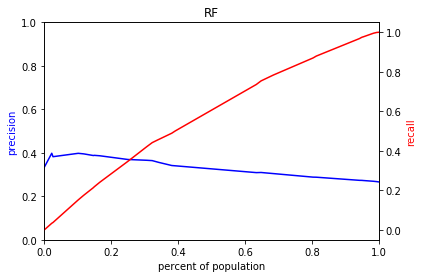

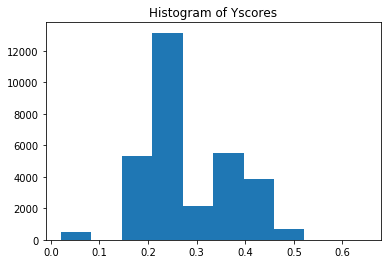

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.555249)
2. Feature resource_type_Supplies (0.069622)
3. Feature primary_focus_area_Math & Science (0.061317)
4. Feature resource_type_Books (0.055551)
5. Feature eligible_double_your_impact_match (0.052975)
6. Feature school_metro_rural (0.050559)
7. Feature total_price_including_optional_support_discrete_med (0.040415)
8. Feature total_price_including_optional_support_discrete_bottom_outlier (0.024675)
9. Feature school_metro_urban (0.017416)
10. Feature poverty_level_high poverty (0.012974)

	Model 87
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
     

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

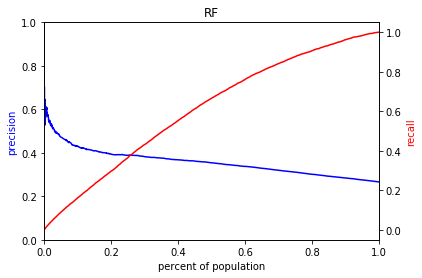

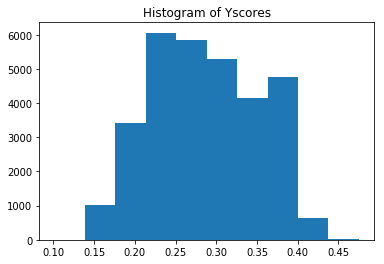

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.276144)
2. Feature total_price_including_optional_support_discrete_low (0.271494)
3. Feature eligible_double_your_impact_match (0.117302)
4. Feature resource_type_Technology (0.103813)
5. Feature school_metro_rural (0.046178)
6. Feature primary_focus_area_Literacy & Language (0.034107)
7. Feature school_metro_urban (0.025580)
8. Feature total_price_including_optional_support_discrete_bottom_outlier (0.014500)
9. Feature total_price_including_optional_support_discrete_med (0.013958)
10. Feature poverty_level_highest poverty (0.009457)

	Model 88
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

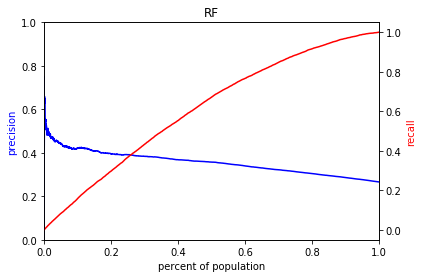

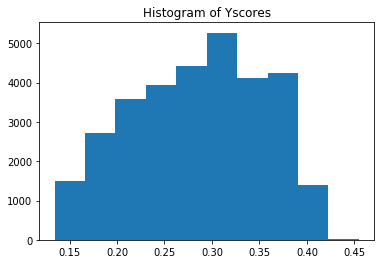

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.275066)
2. Feature total_price_including_optional_support_discrete_high (0.228567)
3. Feature eligible_double_your_impact_match (0.136261)
4. Feature resource_type_Technology (0.088284)
5. Feature total_price_including_optional_support_discrete_med (0.041134)
6. Feature school_metro_urban (0.031331)
7. Feature school_metro_rural (0.021214)
8. Feature total_price_including_optional_support_discrete_top_outlier (0.019512)
9. Feature poverty_level_highest poverty (0.019197)
10. Feature resource_type_Books (0.019118)

	Model 89
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

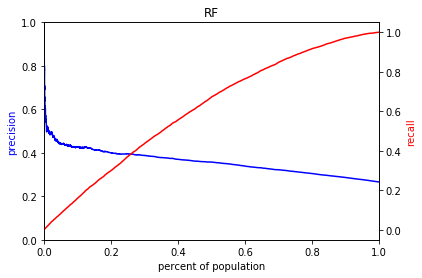

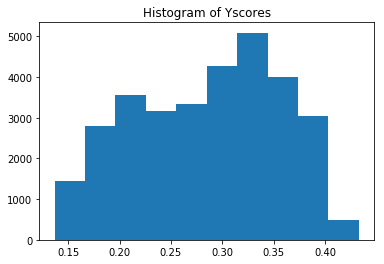

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.313340)
2. Feature total_price_including_optional_support_discrete_high (0.215307)
3. Feature eligible_double_your_impact_match (0.123050)
4. Feature resource_type_Technology (0.077221)
5. Feature total_price_including_optional_support_discrete_med (0.039691)
6. Feature school_metro_urban (0.027180)
7. Feature school_metro_rural (0.023226)
8. Feature resource_type_Books (0.021881)
9. Feature total_price_including_optional_support_discrete_bottom_outlier (0.017713)
10. Feature primary_focus_area_Math & Science (0.017130)

	Model 90
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, rando

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

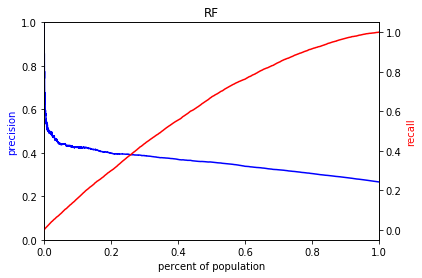

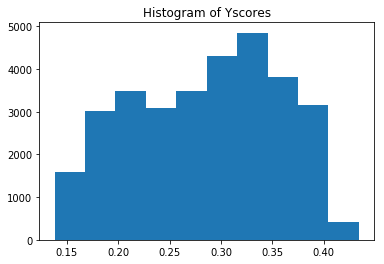

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.311348)
2. Feature total_price_including_optional_support_discrete_high (0.220945)
3. Feature eligible_double_your_impact_match (0.125456)
4. Feature resource_type_Technology (0.074355)
5. Feature total_price_including_optional_support_discrete_med (0.038691)
6. Feature school_metro_urban (0.025849)
7. Feature school_metro_rural (0.022176)
8. Feature resource_type_Books (0.020997)
9. Feature total_price_including_optional_support_discrete_bottom_outlier (0.017443)
10. Feature primary_focus_area_Math & Science (0.017229)

	Model 91
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_sta

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

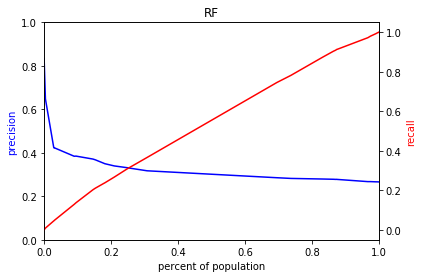

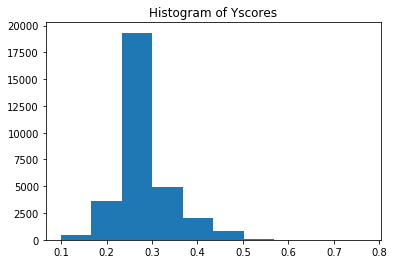

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.299871)
2. Feature resource_type_Supplies (0.122070)
3. Feature school_metro_rural (0.081835)
4. Feature eligible_double_your_impact_match (0.081274)
5. Feature total_price_including_optional_support_discrete_top_outlier (0.072743)
6. Feature school_metro_urban (0.067255)
7. Feature primary_focus_area_Literacy & Language (0.040288)
8. Feature primary_focus_area_Math & Science (0.040121)
9. Feature total_price_including_optional_support_discrete_low (0.039873)
10. Feature poverty_level_moderate poverty (0.031139)

	Model 92
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=Non

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

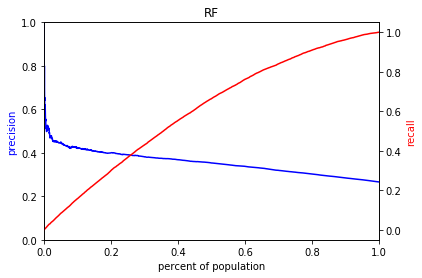

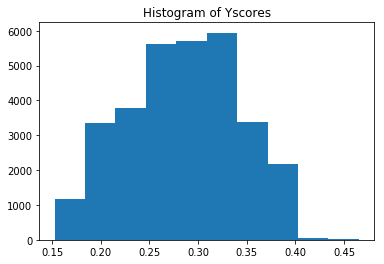

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.291971)
2. Feature total_price_including_optional_support_discrete_high (0.209568)
3. Feature resource_type_Technology (0.095985)
4. Feature resource_type_Supplies (0.060385)
5. Feature eligible_double_your_impact_match (0.053106)
6. Feature resource_type_Books (0.032868)
7. Feature school_metro_rural (0.030365)
8. Feature school_metro_urban (0.029663)
9. Feature poverty_level_highest poverty (0.027882)
10. Feature total_price_including_optional_support_discrete_top_outlier (0.026174)

	Model 93
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            wa

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

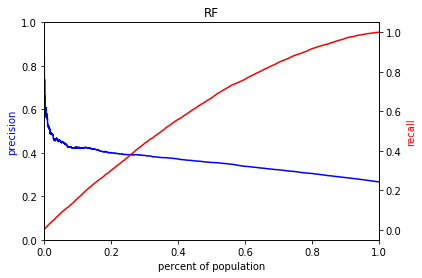

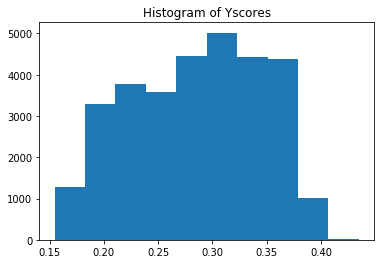

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.308166)
2. Feature total_price_including_optional_support_discrete_high (0.194651)
3. Feature eligible_double_your_impact_match (0.125136)
4. Feature resource_type_Technology (0.086891)
5. Feature school_metro_rural (0.031390)
6. Feature total_price_including_optional_support_discrete_med (0.029954)
7. Feature resource_type_Books (0.028200)
8. Feature school_metro_urban (0.022501)
9. Feature resource_type_Supplies (0.020087)
10. Feature primary_focus_area_Math & Science (0.018226)

	Model 94
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

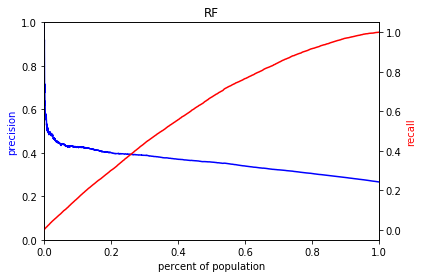

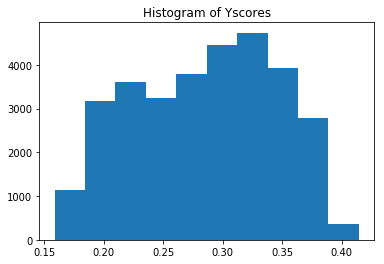

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.283785)
2. Feature total_price_including_optional_support_discrete_high (0.223726)
3. Feature eligible_double_your_impact_match (0.118628)
4. Feature resource_type_Technology (0.082425)
5. Feature total_price_including_optional_support_discrete_med (0.030133)
6. Feature school_metro_urban (0.028362)
7. Feature resource_type_Books (0.024153)
8. Feature school_metro_rural (0.023995)
9. Feature resource_type_Supplies (0.019055)
10. Feature total_price_including_optional_support_discrete_top_outlier (0.019044)

	Model 95
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=None, v

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

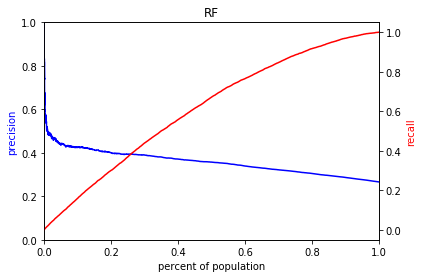

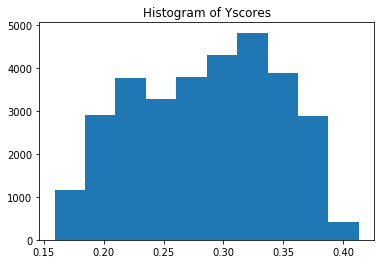

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.286085)
2. Feature total_price_including_optional_support_discrete_high (0.214828)
3. Feature eligible_double_your_impact_match (0.123058)
4. Feature resource_type_Technology (0.084331)
5. Feature total_price_including_optional_support_discrete_med (0.030025)
6. Feature school_metro_urban (0.028019)
7. Feature resource_type_Books (0.025111)
8. Feature school_metro_rural (0.024390)
9. Feature total_price_including_optional_support_discrete_bottom_outlier (0.019192)
10. Feature resource_type_Supplies (0.018769)

	Model 96
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, v

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

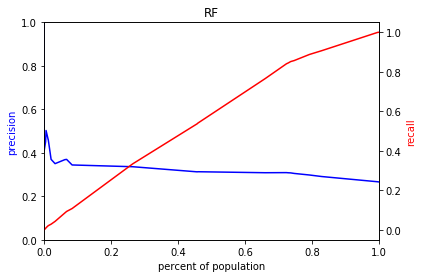

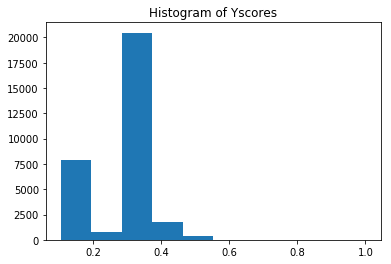

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.534466)
2. Feature total_price_including_optional_support_discrete_high (0.174904)
3. Feature school_metro_rural (0.066147)
4. Feature resource_type_Books (0.058499)
5. Feature eligible_double_your_impact_match (0.041549)
6. Feature primary_focus_area_Literacy & Language (0.038579)
7. Feature total_price_including_optional_support_discrete_top_outlier (0.025175)
8. Feature primary_focus_area_Music & The Arts (0.018592)
9. Feature grade_level_Grades 3-5 (0.015685)
10. Feature students_reached_discrete_high (0.007960)

	Model 97
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

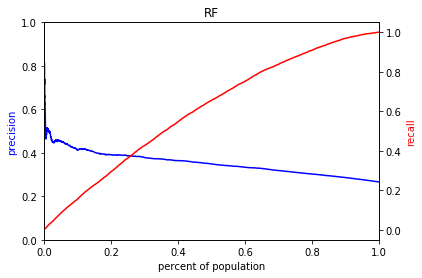

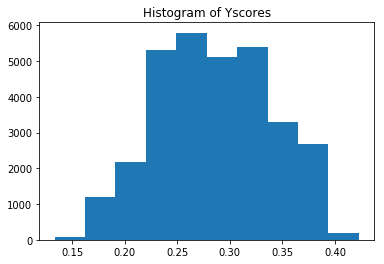

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_high (0.250634)
2. Feature resource_type_Technology (0.181225)
3. Feature eligible_double_your_impact_match (0.132318)
4. Feature total_price_including_optional_support_discrete_low (0.076319)
5. Feature resource_type_Books (0.046523)
6. Feature total_price_including_optional_support_discrete_med (0.044326)
7. Feature school_metro_rural (0.038456)
8. Feature resource_type_Supplies (0.030833)
9. Feature poverty_level_high poverty (0.028151)
10. Feature school_metro_urban (0.024469)

	Model 98
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=F

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

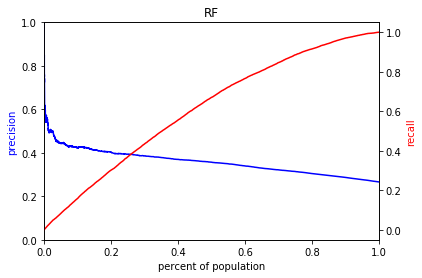

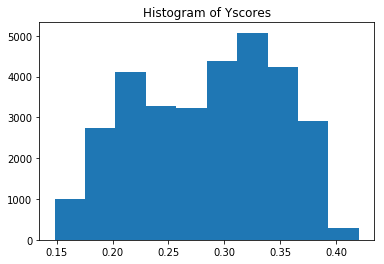

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.315115)
2. Feature total_price_including_optional_support_discrete_high (0.228213)
3. Feature eligible_double_your_impact_match (0.105332)
4. Feature resource_type_Technology (0.069229)
5. Feature resource_type_Books (0.028896)
6. Feature total_price_including_optional_support_discrete_med (0.028632)
7. Feature school_metro_urban (0.024953)
8. Feature school_metro_rural (0.023118)
9. Feature total_price_including_optional_support_discrete_bottom_outlier (0.019587)
10. Feature total_price_including_optional_support_discrete_top_outlier (0.018955)

	Model 99
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
         

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

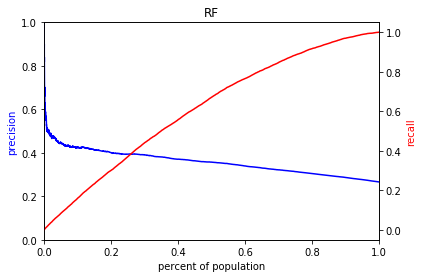

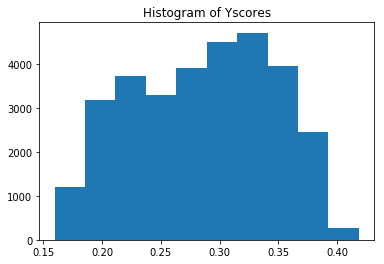

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.289200)
2. Feature total_price_including_optional_support_discrete_high (0.211998)
3. Feature eligible_double_your_impact_match (0.120063)
4. Feature resource_type_Technology (0.087377)
5. Feature total_price_including_optional_support_discrete_med (0.029811)
6. Feature school_metro_urban (0.029053)
7. Feature resource_type_Books (0.025619)
8. Feature school_metro_rural (0.025351)
9. Feature resource_type_Supplies (0.019604)
10. Feature total_price_including_optional_support_discrete_bottom_outlier (0.018722)

	Model 100
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=No

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

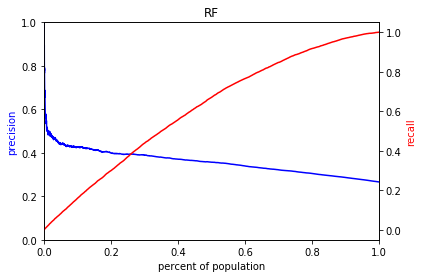

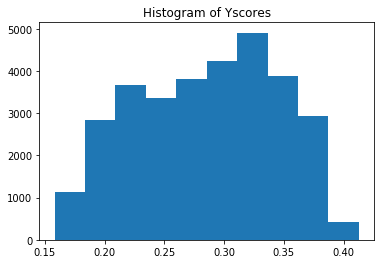

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.285538)
2. Feature total_price_including_optional_support_discrete_high (0.214107)
3. Feature eligible_double_your_impact_match (0.122750)
4. Feature resource_type_Technology (0.084409)
5. Feature total_price_including_optional_support_discrete_med (0.029763)
6. Feature school_metro_urban (0.027836)
7. Feature resource_type_Books (0.025487)
8. Feature school_metro_rural (0.025353)
9. Feature total_price_including_optional_support_discrete_bottom_outlier (0.019713)
10. Feature total_price_including_optional_support_discrete_top_outlier (0.019310)

	Model 101
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
           

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

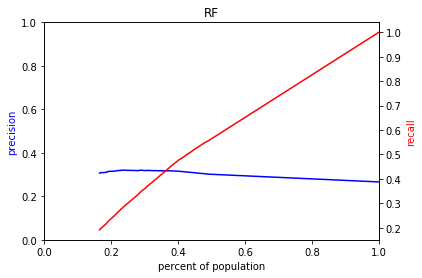

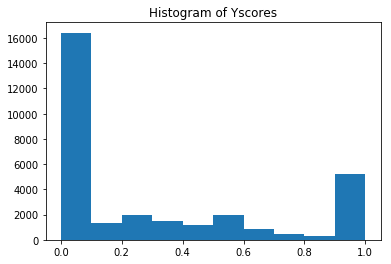

FEATURE IMPORTANCES

1. Feature female_teacher (0.054687)
2. Feature eligible_double_your_impact_match (0.053532)
3. Feature school_magnet (0.042693)
4. Feature secondary_focus_area_nan (0.041392)
5. Feature school_charter (0.040593)
6. Feature students_reached_discrete_med (0.036017)
7. Feature secondary_focus_area_Literacy & Language (0.035535)
8. Feature grade_level_Grades 3-5 (0.035515)
9. Feature students_reached_discrete_low (0.033644)
10. Feature total_price_including_optional_support_discrete_low (0.033624)

	Model 102
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfu

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

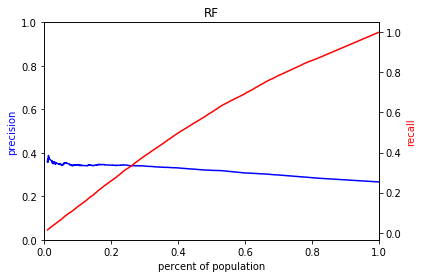

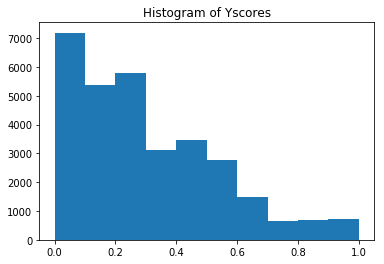

FEATURE IMPORTANCES

1. Feature female_teacher (0.049843)
2. Feature eligible_double_your_impact_match (0.042409)
3. Feature school_magnet (0.040239)
4. Feature school_charter (0.039437)
5. Feature total_price_including_optional_support_discrete_low (0.037321)
6. Feature secondary_focus_area_nan (0.034680)
7. Feature secondary_focus_area_Literacy & Language (0.034561)
8. Feature grade_level_Grades 3-5 (0.034039)
9. Feature students_reached_discrete_med (0.033220)
10. Feature grade_level_Grades PreK-2 (0.032566)

	Model 103
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

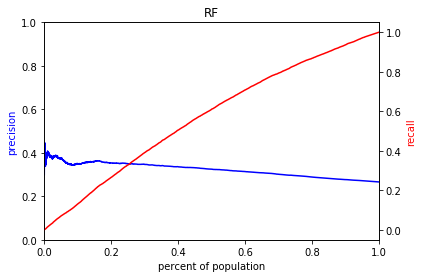

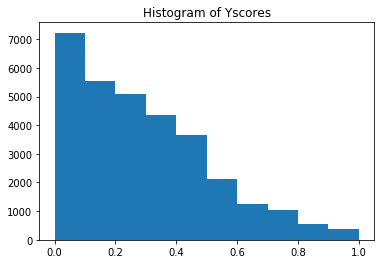

FEATURE IMPORTANCES

1. Feature female_teacher (0.049045)
2. Feature school_magnet (0.039726)
3. Feature school_charter (0.039691)
4. Feature eligible_double_your_impact_match (0.038434)
5. Feature secondary_focus_area_nan (0.037705)
6. Feature grade_level_Grades 3-5 (0.034704)
7. Feature total_price_including_optional_support_discrete_low (0.034370)
8. Feature students_reached_discrete_med (0.034333)
9. Feature students_reached_discrete_low (0.032792)
10. Feature students_reached_discrete_high (0.032127)

	Model 104
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully pred

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

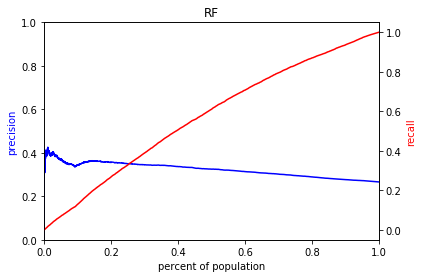

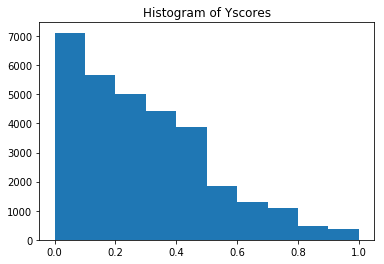

FEATURE IMPORTANCES

1. Feature female_teacher (0.048715)
2. Feature school_magnet (0.039885)
3. Feature school_charter (0.039560)
4. Feature eligible_double_your_impact_match (0.038838)
5. Feature secondary_focus_area_nan (0.037755)
6. Feature grade_level_Grades 3-5 (0.034261)
7. Feature students_reached_discrete_med (0.033782)
8. Feature secondary_focus_area_Literacy & Language (0.032620)
9. Feature students_reached_discrete_low (0.032315)
10. Feature total_price_including_optional_support_discrete_low (0.031804)

	Model 105
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succe

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

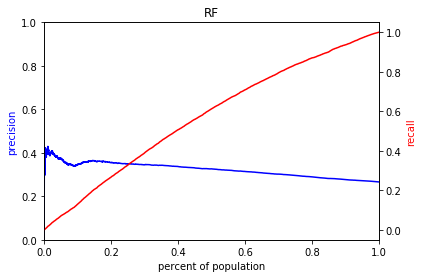

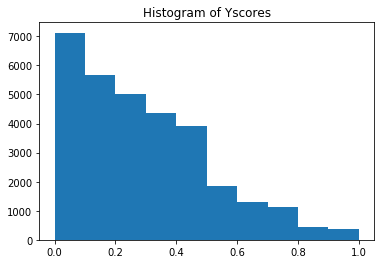

FEATURE IMPORTANCES

1. Feature female_teacher (0.048647)
2. Feature school_charter (0.039914)
3. Feature school_magnet (0.039630)
4. Feature eligible_double_your_impact_match (0.039175)
5. Feature secondary_focus_area_nan (0.037568)
6. Feature grade_level_Grades 3-5 (0.034606)
7. Feature students_reached_discrete_med (0.033773)
8. Feature secondary_focus_area_Literacy & Language (0.032724)
9. Feature students_reached_discrete_low (0.032300)
10. Feature total_price_including_optional_support_discrete_low (0.032299)

	Model 106
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfu

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

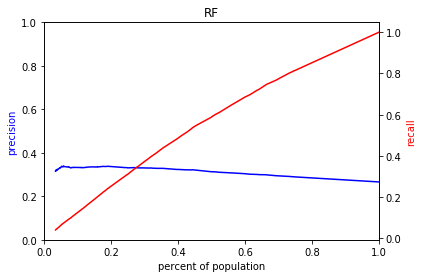

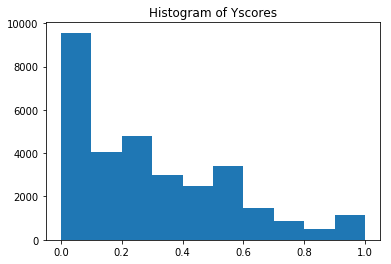

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.070300)
2. Feature eligible_double_your_impact_match (0.041974)
3. Feature female_teacher (0.040801)
4. Feature total_price_including_optional_support_discrete_high (0.038886)
5. Feature school_magnet (0.035795)
6. Feature school_charter (0.034673)
7. Feature secondary_focus_area_Literacy & Language (0.034019)
8. Feature secondary_focus_area_nan (0.031423)
9. Feature secondary_focus_area_Applied Learning (0.029745)
10. Feature grade_level_Grades 3-5 (0.028038)

	Model 107
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succe

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

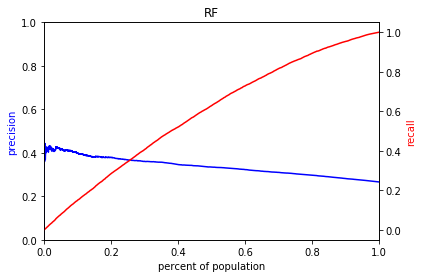

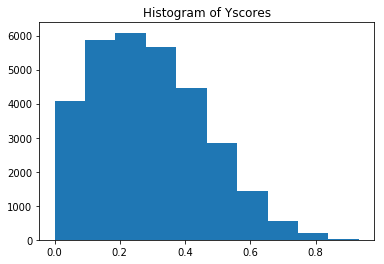

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.070028)
2. Feature eligible_double_your_impact_match (0.042249)
3. Feature total_price_including_optional_support_discrete_high (0.037647)
4. Feature female_teacher (0.037026)
5. Feature school_charter (0.035639)
6. Feature school_magnet (0.035086)
7. Feature secondary_focus_area_nan (0.032472)
8. Feature secondary_focus_area_Literacy & Language (0.030844)
9. Feature students_reached_discrete_low (0.030428)
10. Feature students_reached_discrete_med (0.030408)

	Model 108
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succe

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

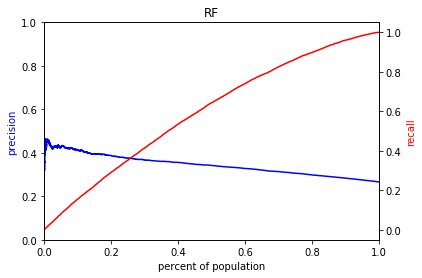

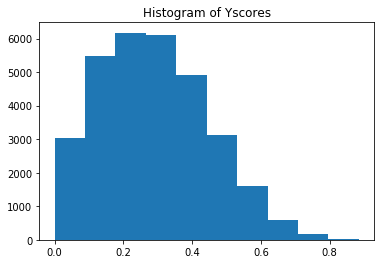

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.057471)
2. Feature total_price_including_optional_support_discrete_high (0.046149)
3. Feature eligible_double_your_impact_match (0.043657)
4. Feature female_teacher (0.035353)
5. Feature school_magnet (0.035176)
6. Feature school_charter (0.034682)
7. Feature secondary_focus_area_nan (0.031597)
8. Feature secondary_focus_area_Literacy & Language (0.029295)
9. Feature grade_level_Grades 3-5 (0.029192)
10. Feature students_reached_discrete_low (0.028368)

	Model 109
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

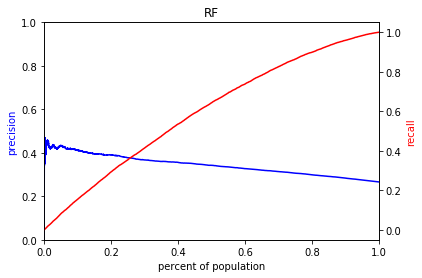

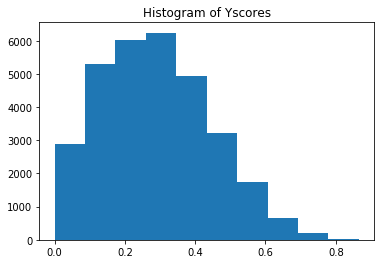

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.060855)
2. Feature eligible_double_your_impact_match (0.043648)
3. Feature total_price_including_optional_support_discrete_high (0.042455)
4. Feature female_teacher (0.036191)
5. Feature school_charter (0.035222)
6. Feature school_magnet (0.034650)
7. Feature secondary_focus_area_nan (0.030920)
8. Feature secondary_focus_area_Literacy & Language (0.028851)
9. Feature grade_level_Grades 3-5 (0.028504)
10. Feature students_reached_discrete_med (0.028215)

	Model 110
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfull

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

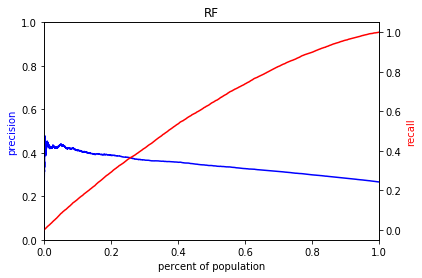

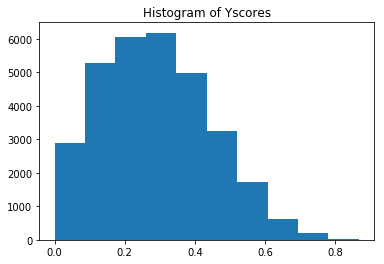

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.059827)
2. Feature eligible_double_your_impact_match (0.043511)
3. Feature total_price_including_optional_support_discrete_high (0.043341)
4. Feature female_teacher (0.036138)
5. Feature school_charter (0.034868)
6. Feature school_magnet (0.034530)
7. Feature secondary_focus_area_nan (0.031180)
8. Feature grade_level_Grades 3-5 (0.028911)
9. Feature secondary_focus_area_Literacy & Language (0.028710)
10. Feature students_reached_discrete_med (0.028377)

	Model 111
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully tra

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

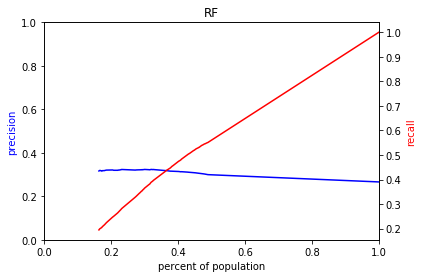

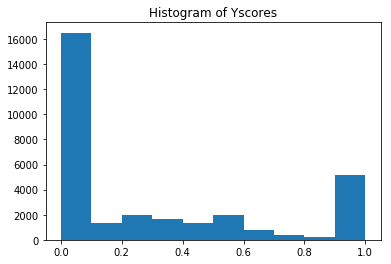

FEATURE IMPORTANCES

1. Feature female_teacher (0.046747)
2. Feature school_charter (0.041983)
3. Feature school_magnet (0.040336)
4. Feature total_price_including_optional_support_discrete_low (0.040217)
5. Feature secondary_focus_area_Literacy & Language (0.033452)
6. Feature students_reached_discrete_med (0.033315)
7. Feature secondary_focus_area_nan (0.033003)
8. Feature grade_level_Grades 3-5 (0.032985)
9. Feature students_reached_discrete_low (0.032525)
10. Feature secondary_focus_area_Applied Learning (0.031731)

	Model 112
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succ

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

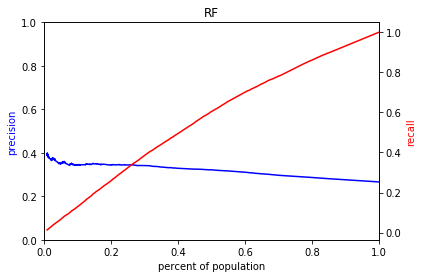

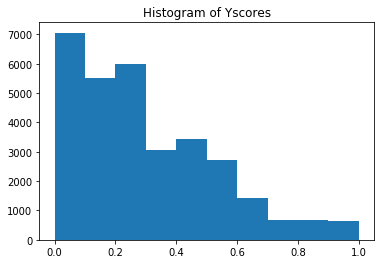

FEATURE IMPORTANCES

1. Feature female_teacher (0.046773)
2. Feature eligible_double_your_impact_match (0.043605)
3. Feature school_magnet (0.037399)
4. Feature secondary_focus_area_nan (0.037366)
5. Feature total_price_including_optional_support_discrete_low (0.036513)
6. Feature school_charter (0.035784)
7. Feature students_reached_discrete_med (0.032175)
8. Feature grade_level_Grades PreK-2 (0.032145)
9. Feature secondary_focus_area_Literacy & Language (0.031947)
10. Feature grade_level_Grades 3-5 (0.031346)

	Model 113
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

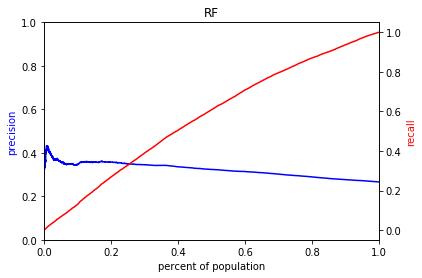

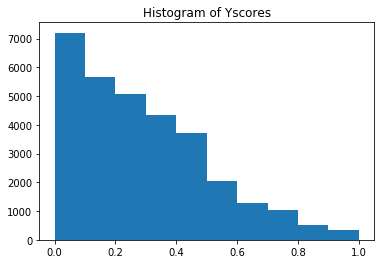

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.050479)
2. Feature female_teacher (0.048995)
3. Feature school_magnet (0.039483)
4. Feature school_charter (0.038527)
5. Feature secondary_focus_area_nan (0.035247)
6. Feature total_price_including_optional_support_discrete_low (0.034666)
7. Feature grade_level_Grades 3-5 (0.033548)
8. Feature students_reached_discrete_med (0.031929)
9. Feature grade_level_Grades PreK-2 (0.030514)
10. Feature students_reached_discrete_low (0.030279)

	Model 114
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfully predicted

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

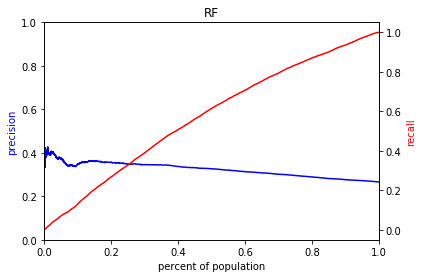

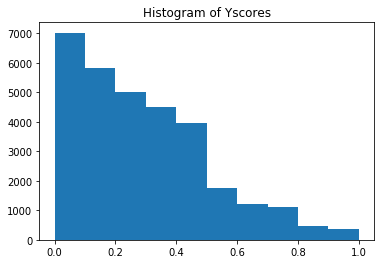

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.047194)
2. Feature female_teacher (0.047123)
3. Feature school_magnet (0.038551)
4. Feature school_charter (0.038338)
5. Feature secondary_focus_area_nan (0.036572)
6. Feature total_price_including_optional_support_discrete_low (0.035420)
7. Feature grade_level_Grades 3-5 (0.032706)
8. Feature students_reached_discrete_med (0.032625)
9. Feature secondary_focus_area_Literacy & Language (0.031452)
10. Feature students_reached_discrete_low (0.031183)

	Model 115
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succe

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

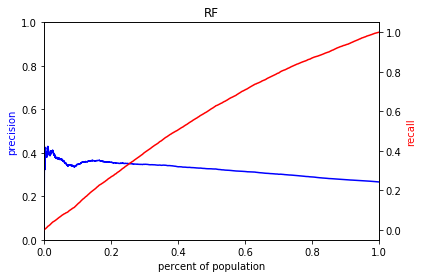

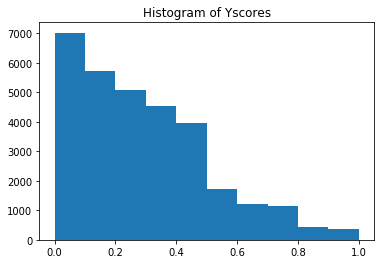

FEATURE IMPORTANCES

1. Feature eligible_double_your_impact_match (0.047735)
2. Feature female_teacher (0.047600)
3. Feature school_magnet (0.038807)
4. Feature school_charter (0.038298)
5. Feature secondary_focus_area_nan (0.036325)
6. Feature total_price_including_optional_support_discrete_low (0.034484)
7. Feature grade_level_Grades 3-5 (0.032798)
8. Feature students_reached_discrete_med (0.032266)
9. Feature secondary_focus_area_Literacy & Language (0.031326)
10. Feature students_reached_discrete_low (0.030926)

	Model 116
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesfu

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

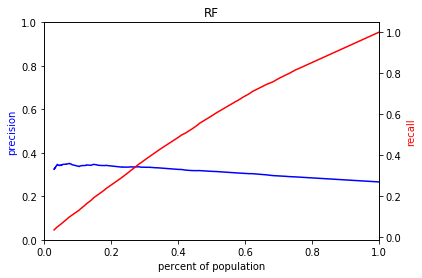

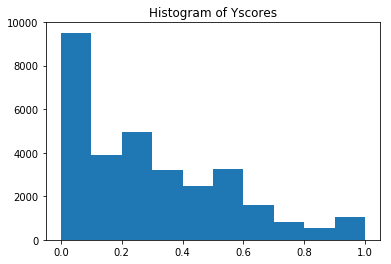

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.082239)
2. Feature eligible_double_your_impact_match (0.044388)
3. Feature school_charter (0.037349)
4. Feature female_teacher (0.036897)
5. Feature total_price_including_optional_support_discrete_high (0.036830)
6. Feature poverty_level_highest poverty (0.034384)
7. Feature poverty_level_high poverty (0.032382)
8. Feature students_reached_discrete_high (0.032312)
9. Feature school_magnet (0.031832)
10. Feature students_reached_discrete_low (0.029893)

	Model 117
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully tr

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

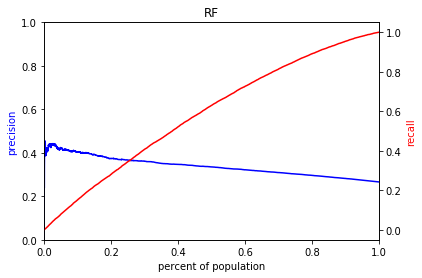

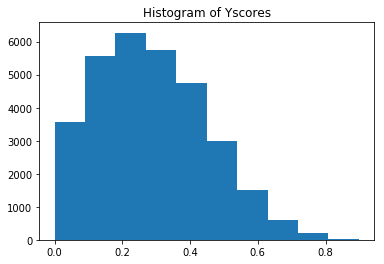

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.068052)
2. Feature eligible_double_your_impact_match (0.046243)
3. Feature total_price_including_optional_support_discrete_high (0.042835)
4. Feature school_charter (0.037545)
5. Feature female_teacher (0.033933)
6. Feature school_magnet (0.032207)
7. Feature grade_level_Grades 3-5 (0.030384)
8. Feature secondary_focus_area_nan (0.029036)
9. Feature grade_level_Grades PreK-2 (0.028577)
10. Feature school_metro_urban (0.027975)

	Model 118
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained model.
		Succesful

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

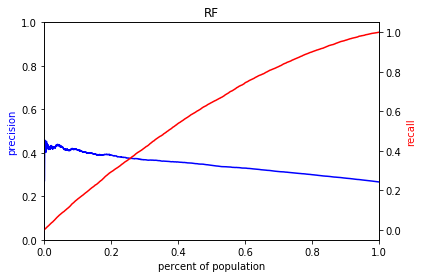

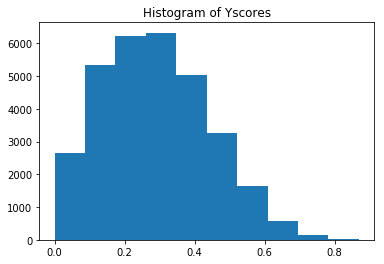

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.067276)
2. Feature eligible_double_your_impact_match (0.049365)
3. Feature total_price_including_optional_support_discrete_high (0.044169)
4. Feature female_teacher (0.034425)
5. Feature school_charter (0.033935)
6. Feature school_magnet (0.033894)
7. Feature secondary_focus_area_nan (0.030077)
8. Feature students_reached_discrete_low (0.027774)
9. Feature students_reached_discrete_med (0.027691)
10. Feature grade_level_Grades 3-5 (0.027226)

	Model 119
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfully trained mo

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

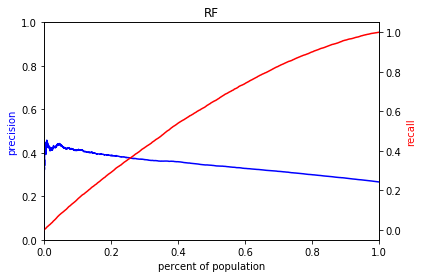

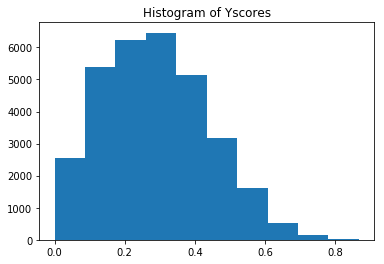

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.062985)
2. Feature total_price_including_optional_support_discrete_high (0.048702)
3. Feature eligible_double_your_impact_match (0.048598)
4. Feature female_teacher (0.035124)
5. Feature school_magnet (0.033973)
6. Feature school_charter (0.033027)
7. Feature secondary_focus_area_nan (0.030052)
8. Feature secondary_focus_area_Literacy & Language (0.027638)
9. Feature grade_level_Grades 3-5 (0.027345)
10. Feature students_reached_discrete_low (0.027012)

	Model 120
		Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
		Succesfull

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

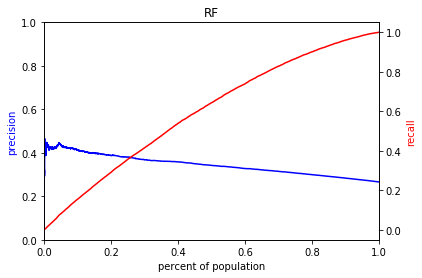

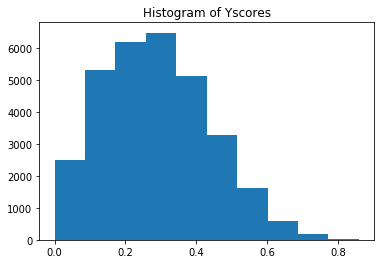

FEATURE IMPORTANCES

1. Feature total_price_including_optional_support_discrete_low (0.062697)
2. Feature eligible_double_your_impact_match (0.048712)
3. Feature total_price_including_optional_support_discrete_high (0.048699)
4. Feature female_teacher (0.034984)
5. Feature school_magnet (0.033882)
6. Feature school_charter (0.033454)
7. Feature secondary_focus_area_nan (0.030149)
8. Feature secondary_focus_area_Literacy & Language (0.027563)
9. Feature grade_level_Grades 3-5 (0.027407)
10. Feature students_reached_discrete_low (0.027226)
Saved file: results/grid_RF_time_12_39_23results.csv


<Figure size 432x288 with 0 Axes>

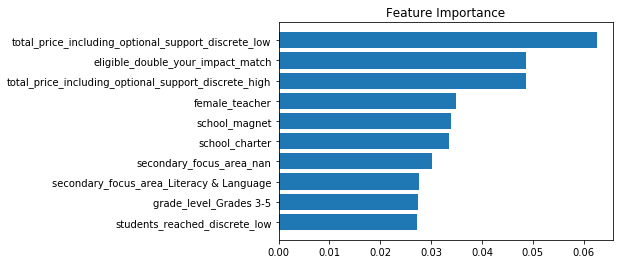

In [28]:
RF_results = cfs.run_clfs_RFs_test(clfs=RF_clf,
                                   grid=RF_grid,
                                   thresholds=[5],
                                  temporal_dfs=temporal_dfs,
                                  plot=True,
                                  save_csv=True)

In [47]:
RF_results.shape

(118, 13)

In [48]:
RF_results

,model_type,clf_details,chosen_params,split_date,start_date_train,end_date_train,start_date_test,end_date_test,random_baseline,p_at_5pct,recall_at_5pct,f1_at_5pct,auc-roc
0,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,0.027754,0.005577,0.009287,0.600332
1,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,0.423244,0.085047,0.141634,0.645677
2,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,0.423244,0.085047,0.141634,0.651184
3,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,0.415438,0.083479,0.139022,0.650296
4,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,0.417173,0.083827,0.139602,0.650882
5,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,0.236774,0.047578,0.079234,0.588539
6,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,0.433651,0.087138,0.145117,0.653306
7,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,0.436253,0.087661,0.145988,0.651512
8,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,0.422376,0.084873,0.141344,0.650891
9,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,0.413703,0.083130,0.138441,0.650632


### For all clfs in grid

In [15]:
#results_med = cfs.run_clfs('med', PARAMS['thresholds'], temporal_dfs)

In [29]:
results_med = pd.read_csv('results/grid_med_time_00_25_40results.csv')

In [17]:
results_med.shape

(558, 32)

In [44]:
results_med.head()

,Unnamed: 0,model_type,clf_details,chosen_params,split_date,start_date_train,end_date_train,start_date_test,end_date_test,random_baseline,...,p_at_20pct,recall_at_20pct,f1_at_20pct,p_at_30pct,recall_at_30pct,f1_at_30pct,p_at_50pct,recall_at_50pct,f1_at_50pct,auc-roc
0,0,RF,"RandomForestClassifier(bootstrap=True, ccp_alp...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,...,0.318300,0.255838,0.283671,0.285487,0.344197,0.312105,0.292516,0.587835,0.390642,0.576174
1,1,RF,"RandomForestClassifier(bootstrap=True, ccp_alp...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,...,0.362316,0.291216,0.322899,0.349668,0.421575,0.382269,0.333969,0.671140,0.446002,0.644003
2,2,RF,"RandomForestClassifier(bootstrap=True, ccp_alp...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,...,0.366002,0.294179,0.326184,0.348367,0.420007,0.380847,0.335183,0.673580,0.447623,0.650081
3,3,RF,"RandomForestClassifier(bootstrap=True, ccp_alp...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,...,0.366219,0.294353,0.326377,0.348077,0.419658,0.380531,0.334837,0.672883,0.447160,0.650987
4,4,RF,"RandomForestClassifier(bootstrap=True, ccp_alp...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2012-07-01,2012-01-01,2012-05-02,2012-07-02,2012-10-31,0.248797,...,0.278621,0.223946,0.248309,0.342440,0.412862,0.374368,0.312982,0.628965,0.417974,0.606404


## 6) Analyze models

### Per type of model

#### Overall higher precision

##### 1) Med grid 

In [19]:
overall = results_med.groupby(['model_type'])\
           .agg({'p_at_5pct': np.median})\
          .sort_values('p_at_5pct', ascending = False)
overall

,p_at_5pct
model_type,
SVM,0.467649
LR,0.465414
RF,0.397630
KNN,0.352979
B,0.340809
GB,0.322214
DT,0.204675


##### 2) Only RF

In [36]:
overall_RF = RF_results.groupby(['model_type'])\
           .agg({'p_at_5pct': np.median})\
          .sort_values('p_at_5pct', ascending = False)
overall_RF

,p_at_5pct
model_type,
RF,0.413382


#### By splits

##### 1) Med grid 

In [38]:
split_dates = [['first', '2012-07-01'],
               ['second', '2012-12-30'],
               ['third', '2013-06-30']]

In [21]:
for split, date in split_dates:
  print(split, date)
  tbl = results_med[results_med.split_date == date]\
              .groupby(['model_type'])\
              .agg({'p_at_5pct': np.median,
                  'recall_at_5pct': np.median,
                  'auc-roc': np.median})\
              .sort_values('p_at_5pct', ascending = False)
  print(tbl)
  print()

first 2012-07-01
            p_at_5pct  recall_at_5pct   auc-roc
model_type                                     
SVM          0.468343        0.094109  0.654871
LR           0.466175        0.093674  0.654779
RF           0.355160        0.071366  0.621376
KNN          0.325239        0.065354  0.567840
B            0.319601        0.064221  0.580876
GB           0.276670        0.055594  0.609952
DT           0.001301        0.000261  0.567701

second 2012-12-30
            p_at_5pct  recall_at_5pct   auc-roc
model_type                                     
SVM          0.537649        0.090044  0.680564
LR           0.532365        0.089159  0.680242
RF           0.462351        0.077434  0.642693
KNN          0.404227        0.067699  0.583294
GB           0.396962        0.066482  0.652213
B            0.373184        0.062500  0.596414
DT           0.192206        0.032190  0.588109

third 2013-06-30
            p_at_5pct  recall_at_5pct   auc-roc
model_type                        

##### 2) Only RF

In [40]:
for split, date in split_dates:
  print(split, date)
  tbl = RF_results[RF_results.split_date == date]\
              .groupby(['model_type'])\
              .agg({'p_at_5pct': np.median,
                  'recall_at_5pct': np.median,
                  'auc-roc': np.median})\
              .sort_values('p_at_5pct', ascending = False)
  print(tbl)
  print()

first 2012-07-01
            p_at_5pct  recall_at_5pct   auc-roc
model_type                                     
RF           0.366869        0.073719  0.627969

second 2012-12-30
            p_at_5pct  recall_at_5pct   auc-roc
model_type                                     
RF           0.459709        0.076991  0.643933

third 2013-06-30
            p_at_5pct  recall_at_5pct   auc-roc
model_type                                     
RF            0.42697        0.080195  0.632608



### Best classifiers

In [82]:
best_cfs = []
for split, date in split_dates:
  split_df = results_med[results_med.split_date == date]
  split_df = split_df[['model_type','p_at_5pct', 'chosen_params']].sort_values('p_at_5pct', ascending = False)
  split_df['rank_{}'.format(split)] = split_df['p_at_5pct'].rank(ascending=False).head(50)
  best_cfs.append(split_df)

In [83]:
best_RFs = []
for split, date in split_dates:
  split_df = RF_results[RF_results.split_date == date]
  split_df = split_df[['model_type','p_at_5pct', 'chosen_params']].sort_values('p_at_5pct', ascending = False)
  split_df['rank_{}'.format(split)] = split_df['p_at_5pct'].rank(ascending=False).head(50)
  best_RFs.append(split_df)

#### RF grid temporal analysis 

In [84]:
RF_first_split = best_RFs[0].rename(columns={'p_at_5pct': "p_at_5pct_first"})
RF_second_split = best_RFs[1].rename(columns={'p_at_5pct': "p_at_5pct_second"})
RF_third_split = best_RFs[2].rename(columns={'p_at_5pct': "p_at_5pct_third"})

In [85]:
RF_first_split.head()

,model_type,p_at_5pct_first,chosen_params,rank_first
7,RF,0.436253,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",1.0
6,RF,0.433651,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2.0
2,RF,0.423244,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",3.5
1,RF,0.423244,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",3.5
18,RF,0.422376,"{'max_depth': 5, 'max_features': 'log2', 'min_...",5.5


In [86]:
RF_first_split.merge(RF_second_split, how='inner', on=['model_type', 'chosen_params'])
#                    .merge(RF_third_split, how='inner', on=['model_type', 'chosen_params'])

TypeError: unhashable type: 'dict'

In [ ]:

RF_ranks = first_split.merge(second_split, how='inner', on=['model_type', 'chosen_params'])\
                   .merge(third_split, how='inner', on=['model_type', 'chosen_params'])
RF_ranks.head(20)

#### Medium grid temporal analysis 

In [78]:
first_split = best_cfs[0].rename(columns={'p_at_5pct': "p_at_5pct_first"})
second_split = best_cfs[1].rename(columns={'p_at_5pct': "p_at_5pct_second"})
third_split = best_cfs[2].rename(columns={'p_at_5pct': "p_at_5pct_third"})

In [80]:
first_split.head()

,model_type,p_at_5pct_first,chosen_params,rank_first
52,SVM,0.480486,{'C': 10},1.0
50,SVM,0.478751,{'C': 0.1},2.0
44,LR,0.477884,"{'C': 10, 'penalty': 'l1'}",3.5
45,LR,0.477884,"{'C': 10, 'penalty': 'l2'}",3.5
42,LR,0.477016,"{'C': 1, 'penalty': 'l1'}",5.0


In [79]:
ranks = first_split.merge(second_split, how='inner', on=['model_type', 'chosen_params'])\
                   .merge(third_split, how='inner', on=['model_type', 'chosen_params'])
ranks.head(20)

,model_type,p_at_5pct_first,chosen_params,rank_first,p_at_5pct_second,rank_second,p_at_5pct_third,rank_third
0,SVM,0.480486,{'C': 10},1.0,0.546896,1.0,0.458680,12.5
1,SVM,0.478751,{'C': 0.1},2.0,0.541612,2.5,0.458680,12.5
2,LR,0.477884,"{'C': 10, 'penalty': 'l1'}",3.5,0.532365,12.5,0.464446,7.5
3,LR,0.477884,"{'C': 10, 'penalty': 'l2'}",3.5,0.532365,12.5,0.464446,7.5
4,LR,0.477016,"{'C': 1, 'penalty': 'l1'}",5.0,0.535007,7.0,0.465086,5.5
5,SVM,0.476149,{'C': 1},6.0,0.541612,2.5,0.459321,11.0
6,LR,0.475282,"{'C': 1, 'penalty': 'l2'}",7.0,0.532365,12.5,0.465086,5.5
7,SVM,0.468343,{'C': 0.01},8.0,0.537649,5.0,0.461243,9.0
8,LR,0.466609,"{'C': 0.1, 'penalty': 'l2'}",9.0,0.532365,12.5,0.470211,2.0
9,LR,0.465742,"{'C': 0.1, 'penalty': 'l1'}",10.0,0.533686,9.5,0.467008,4.0


In [28]:
ranks = first_split.merge(second_split, how='inner', on=['model_type', 'chosen_params'])\
                   .merge(third_split, how='inner', on=['model_type', 'chosen_params'])
ranks['sum_ranks'] = ranks['rank_first'] + ranks['rank_second'] + ranks['rank_third']
ranks['median_ranks'] = np.median(ranks[['rank_first', 'rank_second','rank_third']], axis=1) 
ranks.sort_values('median_ranks', ascending = True).head(5)

,model_type,p_at_5pct_first,chosen_params,rank_first,p_at_5pct_second,rank_second,p_at_5pct_third,rank_third,sum_ranks,median_ranks
0,SVM,0.480486,{'C': 10},1.0,0.546896,1.0,0.458680,12.5,14.5,1.0
1,SVM,0.478751,{'C': 0.1},2.0,0.541612,2.5,0.458680,12.5,17.0,2.5
17,GB,0.421509,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",18.5,0.540291,4.0,0.472133,1.0,23.5,4.0
4,LR,0.477016,"{'C': 1, 'penalty': 'l1'}",5.0,0.535007,7.0,0.465086,5.5,17.5,5.5
5,SVM,0.476149,{'C': 1},6.0,0.541612,2.5,0.459321,11.0,19.5,6.0


In [29]:
models_and_params = ranks.sort_values('median_ranks', ascending = True).head(5)
models_and_params = models_and_params[['model_type','chosen_params']]
best_5_to_plot = pd.DataFrame(columns=['model_type', 'chosen_params', 'p_at_5pct', 'split_date'])
for i, split in enumerate(best_cfs):
  best_5 = models_and_params.merge(split)
  best_5['split_date'] = split_dates[i][1]
  best_5 = best_5[['model_type', 'chosen_params', 'p_at_5pct', 'split_date']]
  best_5_to_plot = best_5_to_plot.append(best_5)

In [30]:
best_5_to_plot["model"] = best_5_to_plot.model_type + " params: " + best_5_to_plot.chosen_params
best_5_to_plot.drop(columns=['model_type', 'chosen_params'], inplace=True)

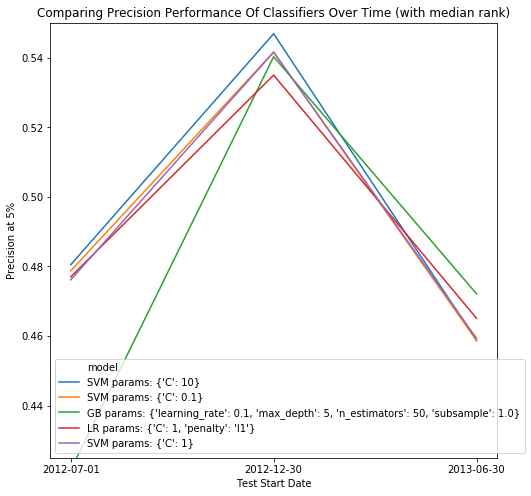

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(x="split_date", y="p_at_5pct", hue="model",
             data=best_5_to_plot, ax=ax)
ax.set_ylim(0.425, 0.55)
ax.set_xlabel("Test Start Date")
ax.set_ylabel("Precision at 5%")
ax.set_title("Comparing Precision Performance Of Classifiers Over Time (with median rank)")
plt.savefig('results/figures/cfs_precision_over_time.png')
plt.show()

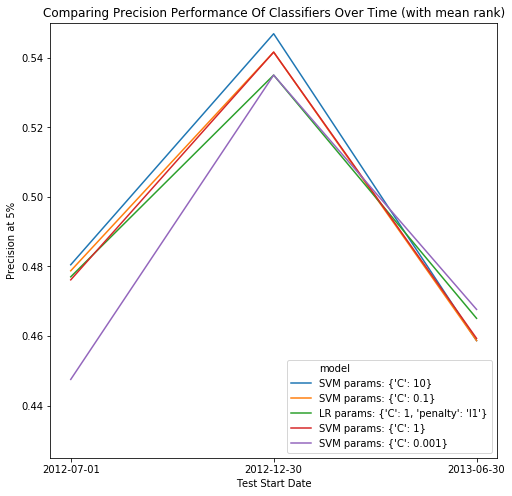

In [32]:
models_and_params = ranks.sort_values('sum_ranks', ascending = True).head(5)
models_and_params = models_and_params[['model_type','chosen_params']]
best_5_to_plot = pd.DataFrame(columns=['model_type', 'chosen_params', 'p_at_5pct', 'split_date'])
for i, split in enumerate(best_cfs):
  best_5 = models_and_params.merge(split)
  best_5['split_date'] = split_dates[i][1]
  best_5 = best_5[['model_type', 'chosen_params', 'p_at_5pct', 'split_date']]
  best_5_to_plot = best_5_to_plot.append(best_5)

best_5_to_plot["model"] = best_5_to_plot.model_type + " params: " + best_5_to_plot.chosen_params
best_5_to_plot.drop(columns=['model_type', 'chosen_params'], inplace=True)

fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(x="split_date", y="p_at_5pct", hue="model",
             data=best_5_to_plot, ax=ax)
ax.set_ylim(0.425, 0.55)
ax.set_xlabel("Test Start Date")
ax.set_ylabel("Precision at 5%")
ax.set_title("Comparing Precision Performance Of Classifiers Over Time (with mean rank)")
plt.savefig('results/figures/cfs_precision_over_time.png')
plt.show()

### Plot

Selecting the specific model with the highest precision for each type of model.

In [33]:
summary = pd.pivot_table(results_med,
                         index=['model_type', 'split_date'],
                         aggfunc='max',
                         fill_value=0)
clean_summary = summary[['chosen_params', 'p_at_5pct']]

In [34]:
clean_summary.chosen_params.unique()

array(["{'n_estimators': 1}",
       "{'criterion': 'gini', 'max_depth': 50, 'max_features': None, 'min_samples_split': 5}",
       "{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}",
       "{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}",
       "{'C': 1e-05, 'penalty': 'l2'}",
       "{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1}",
       "{'C': 1}"], dtype=object)

In [35]:
results_to_plot = summary.reset_index()[['model_type', 'split_date', 'p_at_5pct']]

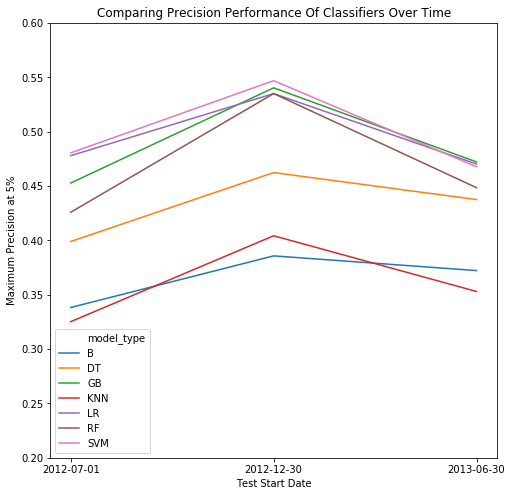

In [36]:
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(x="split_date", y="p_at_5pct", hue="model_type",
             data=results_to_plot, ax=ax)
ax.set_ylim(0.2, 0.6)
ax.set_xlabel("Test Start Date")
ax.set_ylabel("Maximum Precision at 5%")
ax.set_title("Comparing Precision Performance Of Classifiers Over Time")
plt.savefig('results/figures/precision_over_time.png')
plt.show()

## 7) Choose model and save predicted

In [139]:
best_model = LinearSVC(C=10)
last_split = temporal_dfs[pd.Timestamp('2013-06-30 00:00:00')]
train_df = last_split['train']['df']
test_df = last_split['test']['df']
predictions = cfs.get_predictions(best_model, train_df, test_df)

In [140]:
predictions.head()

,school_charter,school_magnet,eligible_double_your_impact_match,female_teacher,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,grade_level_nan,poverty_level_high poverty,...,students_reached_discrete_high,students_reached_discrete_top_outlier,students_reached_discrete_nan,prediction,projectid,teacher_acctid,schoolid,school_ncesid,total_price_including_optional_support,students_reached
20347,0,0,0,1,1,0,0,0,0,1,...,0,0,0,1,29fb233866e02e7e47a0a0ea87effdf6,43eba83fad48a4ef659b5f71594583f9,9a83f1acb2a402e1e9fa7701be819dff,2.80216E+11,5296.01,44.0
7613,0,0,0,1,1,0,0,0,0,1,...,0,0,0,1,0fdb3127bb18cadeb81519991f8a19f0,64860c4b6c79e6f68cc15688844587ab,4db0fbdd64a68887084522593cade610,1.50003E+11,9037.18,50.0
91117,0,1,0,1,1,0,0,0,0,1,...,1,0,0,1,ba7b53f88d08101a206acf9a161ddc1a,18db914e27de91e4f4c88fbc56403e8c,3fe7b9354e0e39897cadbfd6aea0fd5b,4.82364E+11,2986.87,750.0
122811,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,fba78f7fc86721dbf73b8c6855a1e782,f7f273a525701e1bd516982f8fe59583,b57bd9a1810edc98f69c8ae1ac5f338f,1.3024E+11,8577.69,21.0
67623,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,8a7e54b874a709e83ae94c13afaf9896,e9b55d64d775cfc73f4f257d65f910e9,e1b7fdb65eefbedac3b22cedd5e1f70e,3.70048E+11,6438.99,20.0


In [141]:
predictions.prediction.value_counts()

0    29668
1     1561
Name: prediction, dtype: int64

In [ ]:
train_df = last_split['train'][''][]
test_df = last_split['test']['df']